<b>TP : SVM</b>
<br>Mohamed SANAD

# Importation des paquets

In [1]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib.colors import ListedColormap
import pylab as pl
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve, LearningCurveDisplay

# Fonctions utiles

In [2]:
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']

def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

In [3]:
def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f([vec]) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

# Rappels sur les SVM :

On donne un ensemble d’apprentissage ${\left\{(x_i,y_i)\right\}}_{i=1,...,n}$
 où $x_i ∈ X$ (souvent $X = R^d$) et $y_i ∈ \left\{−1,+1\right\}$. Dans un problème de classification à deux classes, le but est (en utilisant les données d’apprentissage ${\left\{(x_i,y_i)\right\}}_{i=1,...,n}$ bien sûr) de chercher une fonction $f: X → R$ qui permet de prédire si un nouvel exemple $x ∈ X$ appartient à la classe $−1$ ou à la classe $+1$.
 
Le principe est de séparer l’espace de descripteurs $X$ en deux parties : $X = \left\{x ∈ X~|~f(x) > 0\right\} ∪ \left\{x ∈ X~|~f(x) < 0\right\}$. Si $f(x) > 0$ alors $x$ est affecté à la classe $+1$, et si $f(x) < 0$ alors $x$ est affecté à la classe $-1$, et si $f(x) = 0$ alors $x$ se trouve sur la <i>« surface de séparation »</i> entre les deux classes et le classifieur ne peut pas l’affecter à aucune classe.

Pour un problème de classification linéaire on suppose que les deux classes ($-1$ et $+1$) sont séparables par un hyperplan. On considère $X = R^d$ et donc un vecteur $x$ a $d$ composantes numériques $x = (x_1,…,x_d)$. Un hyperplan $f(x)$ a donc la forme suivante :
<br> $$ f(x) = \sum_{i=1}^{n}w_i.x_i + b = w^T.x + b = ⟨w,x⟩ + b $$

Ce qui permet de prédire la classe de x :
<br>$$
\hat{y} = 
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad f(x) > 0 \\
    -1 & \quad \text{si} \quad f(x) < 0
    \end{split}
\end{cases}
$$

<img src="https://cedric.cnam.fr/vertigo/cours/ml2/_images/svm_lineaire.png" width="400">
<br><center><i>Problème de séparation linéaire à deux classes : quel est le meilleur hyperplan parmi tous ceux qui séparent les données ?</i></center>

Pour juger la qualité d’un hyperplan en tant que séparateur on utilise la distance entre les exemples d’apprentissage et ce séparateur. Plus précisément, la <i>«marge»</i> d’un problème d’apprentissage est définie comme la distance entre le plus proche exemple d’apprentissage et l’hyperplan de séparation. Pour un hyperplan $H$ on a :
<br> $$ Marge(H) = \mathop{Min}_{x_i}~d(x_i, H) $$

Les SVM linéaires cherchent le séparateur (l’hyperplan de séparation) qui maximise la marge. On appelle cela <i>« séparateur à vaste marge »</i>. Le séparateur idéal correspond intuitivement à l’hyperplan qui passe « au milieu » entre les données sans préférence pour une classe ou une autre. C’est le séparateur de marge maximale.

<img src="https://cedric.cnam.fr/vertigo/cours/ml2/_images/svm_marge_maximale.png" width="400">

Les éléments de la classe $-1$ les plus proches de ce séparateur se trouvent à la même distance du séparateur que les éléments les plus proches de la classe $1$ (cette distance est égale à la marge). Ces éléments, soit d’une classe soit de l’autre, s’appellent <i>« vecteurs de support »</i>.

<img src="https://cedric.cnam.fr/vertigo/cours/ml2/_images/svm_vecteurs_support.png" width="550">

### Données linéairement séparables :

On suppose d’abord que les données d’apprentissage sont linéairement séparables, c’est à dire qu’il existe un hyperplan qui sépare les données sans erreur. Dans ce cas, on cherche l’hyperplan de marge maximale :
<br> $$ f(x) = \sum_{i=1}^{n}w_i.x_i + b = w^T.x + b = ⟨w,x⟩ + b $$

Si $x_s$ est un vecteur de support et $H$ est un hyperplan tel que $H = \left\{x~|~w^T.x + b = 0\right\}$, alors la marge est donnée par :

$$ Marge = 2.d(x, H) = 2.\frac{|w^T.x_s + b|}{||w||} $$

En fait cette quantité est deux fois la marge (par rapport à la définition donnée en haut). On utilise cette quantité pour des raisons de simplicité de l’écriture des équations plus tard, mais ceci ne change en rien le problème d’optimisation (maximiser la marge ou deux fois la marge conduit à la même solution).

Les paramètres $w$ et $b$ ne sont pas uniques, $k.w$ et $k.b$ donnent la même surface de séparation :

$$ k.w^T.x + k.b = k.(w^T + b) = 0 $$

On impose alors la condition de normalisation $|w^⊤.x_s + b| = 1$ pour les vecteurs de support $x_s$, ce qui conduit à :

$$ Marge = \frac{2}{||w||} $$

On arrive donc au problème d’optimisation suivant <i>(appelé problème primal)</i> :

$$ \mathop{Min}_{w,b}~\frac{1}{2}.||w||^2 \quad \text{tel que}\quad y_i.(w^T⋅x_i + b ) ≥ 1,~i=1,…,n $$

Rappelons la condition de normalisation : $w^T⋅x_i + b = 1$ si $x_i$ est un vecteur de support de la classe $+1$ et $w^T⋅x_i + b = −1$ si $x_i$ est un vecteur de support de la classe $-1$. Dans ce cas, comme le problème est séparable, il n’y a pas d’exemple d’apprentissage entre les deux hyperplans $H_{1} = \left\{x~|~w^T.x + b = 1\right\}$ et $H_{-1} = \left\{x~|~w^T.x + b = -1\right\}$.

➤ Si $y_i = 1$ alors $w^T⋅x_i + b ≥ 1$ donc $y_i.(w^T⋅x_i + b) ≥ 1$
<br>➤ Si $y_i = -1$ alors $w^T⋅x_i + b ≤ -1$ donc $y_i.(w^T⋅x_i + b) ≥ 1$

ce qui explique les conditions présentes dans le problème d’optimisation.

La résolution de ce problème peut se faire directement par des méthodes stochastique de type Gauss-Seidel, algorithmes de point intérieur, de type Newton ou de type gradient conjugué.

Il est toutefois mieux de passer à la formulation duale de ce problème. On peut d´efinir une nouvelle fonction objectif: la somme de la fonction à minimiser + la somme des contraintes multipliées par des coefficients positifs, dits de Lagrange :

On a :
<br>$$ \mathop{Min}_{w,b}~\frac{1}{2}.||w||^2 \quad \text{tel que}\quad 1 - y_i.(w^T⋅x_i + b ) ≤ 0,~i=1,…,n $$

Donc :
<br>$$ L(w, b, α) = \frac{1}{2}.||w||^2 + \sum_{i=1}^{n}α_i.[~1 - y_i.(w^T⋅x_i + b)~] $$
<br>Avec : $ ∀i, α_i ≥ 0 $

Le lagrangien doit être optimisé par rapport à w, b et les multiplicateurs α. La solution de ce problème convexe sous contraintes d’inégalités affines peut être obtenue en résolvant le problème suivant :
.
$$ \mathop{Min}_{w}~\mathop{Max}_{α}~L(w, b, α) $$

Nous pouvons également intervertir le min et le max, càd écrire ce problème sous la forme : $ \mathop{Max}_{α}\mathop{Min}_{w}L(w, b, α) $


En annulant les dérivées partielles du lagrangien par rapport à $w$ et $b$, on obtient les relations :

$$ \frac{∂L}{∂b} = 0~~➜~~\sum_{i=1}^{n}α_i.y_i = 0 $$
$$ \frac{∂L}{∂w} = 0~~➜~~w = \sum_{i=1}^{n}α_i.y_i.x_i  $$

Par substitution dans l’équation du lagrangien en haut on obtient le problème dual :
$$ L(α) = \sum_{i=1}^{n}α_i - \frac{1}{2}.||w||^2 $$

En effet : $ \sum_{i=1}^{n}α_i.[~1 - y_i.(w^T⋅x_i + b )~] ~=~ \sum_{i=1}^{n}α_i - w^T.w - b.\sum_{i=1}^{n}α_i.y_i ~=~ \sum_{i=1}^{n}α_i - ||w||^2 $

Et on a : $ ||w||^2 ~=~ \sum_{i=1}^{n}\sum_{j=1}^{n}α_i.α_j.y_i.y_j.x_i^T.x_j $

Donc :
$$ L(α) = \sum_{i=1}^{n}α_i - \frac{1}{2}.\sum_{i=1}^{n}\sum_{j=1}^{n}α_i.α_j.y_i.y_j.x_i^T.x_j $$

On doit maximiser $L(α)$ sous les contraintes :

➤ $~∀i = 1,...,n : α_i ≥ 0$
<br>➤ $~\sum_{i=1}^{n}α_i.y_i = 0$

La solution du problème dual donne les multiplicateurs de Lagrange optimaux $α_i$. A partir des $α_i$, on obtient $w$ par les relations en haut. Le paramètre $b$ est obtenu à partir de la relation $|w^T.x_s + b| = 1$ valable pour tous les vecteurs de support $x_s$.

Observation : les vecteurs de support sont ceux pour lesquels $α_i > 0$. En général leur nombre est beaucoup plus petit que le nombre total d’éléments dans la base d’apprentissage. Ajouter des échantillons qui ne sont pas des vecteurs supports à l’ensemble d’apprentissage n’a aucune influence sur la solution finale, c’est à dire seulement les vecteurs de support interviennent dans la fonction de décision (l’expression de la surface séparatrice entre les deux classes). 

Cette fonction de décision permettant de classer une nouvelle observation $x$ est donnée par :
$$ f(x) = (\sum_{i=1}^{n}α_i.y_i.x_i^T).x + b $$

### Données non linéairement séparables :

Souvent il arrive que même si le problème est linéaire, les données sont affectées par un bruit et les deux classes se retrouvent mélangées autour de l’hyperplan de séparation. Pour gérer ce type de problème on utilise une technique dite de marge souple, qui tolère les mauvais classements. Il faut alors relâcher les contraintes $y_i.(w^T⋅x_i + b ) ≥ 1$ et autoriser $y_i.(w^T⋅x_i + b ) ≥ 1 − ξ_i$ avec le terme d'erreur $ξ_i ≥ 0$.

<img src="https://cedric.cnam.fr/vertigo/cours/ml2/_images/svm_marge_relachement.png" width="550">

Nous avons donc deux situations :

● Pas d’erreur : $y_i.(w^T⋅x_i + b) ≥ 1~~➜~~ξ_i = 0$
<br>● Erreur : $y_i.(w^T⋅x_i + b) < 1~~➜~~ξ_i = 1 - y_i.(w^T⋅x_i + b) > 0$

On associe à cette définition une fonction coût appelée <i>« coût charnière »</i> :

$$ ξ_i = max~(0, 1 - y_i.(w^T⋅x_i + b)) $$

Le problème d’optimisation dans le cas des données non-séparables est donc :

$$
\mathop{Min}_{w,b}~
\begin{cases}
    \frac{1}{2}.||w||^2 \\
    \sum_{i=1}^{n}ξ_i
\end{cases}
$$

tel que :
$$ y_i.(w^T⋅x_i + b) ≥ 1 - ξ_i\quad \text{et} \quadξ_i ≥ 0~,~i=1,...,n $$

Si toutes les variables d’écart $ξ_i = 0$, on retrouve le problème linéairement séparable traité plus tôt.

Puisqu’il faut minimiser les deux termes simultanément, on introduit une variable d’équilibrage $C > 0$ qui permet d’avoir une seule fonction objectif dans le problème d’optimisation :
$$ \mathop{Min}_{w,b} ~ \frac{1}{2}.||w||^2 + C.\sum_{i=1}^{n}ξ_i $$

$C$ est une variable de pénalisation des points mal classés faisant un compromis entre la largeur de la marge et les points mal classés. Les variables $ξ_i$ s’appellent aussi <i>variables ressort</i> (anglais: <i>slack variables</i>).

<img src="https://user.oc-static.com/upload/2019/06/24/15614000831158_NonLinSeparableSVMBigC.png" width="500">
<center><i>Une grande valeur de C conduit à une petite marge.</i></center>
<br>
<img src="https://user.oc-static.com/upload/2019/06/24/15613998985268_NonLinSeparableSVMSmallC.png" width="500">
<center><i>En diminuant C on agrandit la marge.</i></center>

Par la même procédure qu’avant, on obtient le problème dual : $ \mathop{Max}_{α}~L(α) $

Tel que :
$$ L(α) = \sum_{i=1}^{n}α_i - \frac{1}{2}.\sum_{i=1}^{n}\sum_{j=1}^{n}α_i.α_j.y_i.y_j.x_i^T.x_j $$
Avec :
<br>➤ $~∀i = 1,...,n : 0 ≤ α_i ≤C$
<br>➤ $~\sum_{i=1}^{n}α_i.y_i = 0$

Observations :

● $C$ joue le rôle d’une constante de régularisation (la régularisation est d’autant plus forte que $C$ est proche de 0).
<br>● La différence pour le problème dual entre le cas séparable et non séparable est que les valeurs des $α_i$ sont majorées par $C$.
<br>● Les points mal classés ou placés dans la marge ont un $α_i = C$.
<br>● Les points bien classés et placés hors de la marge ont un $α_i = 0$.
<br>● $b$ est calculé de sorte que $y_i.(w^T.x_i + b) = 1$ pour les points tels que $0 < α_i < C$.

La fonction de décision permettant de classer une nouvelle observation $x$ est toujours :
$$ f(x) = (\sum_{i=1}^{n}α_i.y_i.x_i^T).x + b $$

### Méthode des noyaux :

Le principe de cette méthode est d’appliquer l’algorithme linéaire sur une projection des données dans un espace de dimension (en général) plus grande dans lequel les données seront linéairement séparables.

Par le théorème de Mercer, si $K$ est un noyau défini positif $(K : R^d × R^d → R)$, alors il existe une transformation $ϕ : R^d → H$ vers $H$ espace de Hilbert tel que : $K(x,y) = ⟨ϕ(x),ϕ(y)⟩$

Les données $x_i$ sont projetées dans l’espace $H$ de très grande dimension, $x_i → ϕ(x_i)$. Dans $H$, les projections $ϕ(x_i)$ ont plus de chances d’être séparables linéairement.

Le problème d’optimisation dans l’espace $H$ est :
$$ \mathop{Min}_{w,b} ~ \frac{1}{2}.||w||^2 + C.\sum_{i=1}^{n}ξ_i $$
tel que :
$$ y_i.(w^T⋅ϕ(x_i) + b) ≥ 1 - ξ_i\quad \text{et} \quadξ_i ≥ 0~,~i=1,...,n $$

Le problème dual est donc : $ \mathop{Max}_{α}~L(α) $

Tel que :
$$ L(α) = \sum_{i=1}^{n}α_i - \frac{1}{2}.\sum_{i=1}^{n}\sum_{j=1}^{n}α_i.α_j.y_i.y_j.⟨ϕ(x_i),ϕ(x_j)⟩ $$
Avec :
<br>➤ $~∀i = 1,...,n : 0 ≤ α_i ≤C$
<br>➤ $~\sum_{i=1}^{n}α_i.y_i = 0$

Mais par l’astuce des noyaux $⟨ϕ(x_i),ϕ(x_j)⟩ = K(x_i,x_j)$ le problème peut être résolu sans avoir à trouver la projection $ϕ$ (ce qui est souvent très difficile).
$$ L(α) = \sum_{i=1}^{n}α_i - \frac{1}{2}.\sum_{i=1}^{n}\sum_{j=1}^{n}α_i.α_j.y_i.y_j.K(x_i,x_j) $$

La fonction de décision permettant de classer une nouvelle observation $x$ est donnée par :
$$ f(x) = \sum_{i=1}^{n}α_i.y_i.K(x_i,x) + b $$

# SVM et noyaux pour la classification binaire (dataset iris)

### Question 1 :

In [4]:
scaler = StandardScaler()
iris = datasets.load_iris()
X = iris.data
X = scaler.fit_transform(X)
y = iris.target
X = X[y != 0, :2]
y = y[y != 0]

In [5]:
print("Nombre d'observations appartenant à la classe 1 : = "+str(len(y[y==1])))
print("Nombre d'observations appartenant à la classe 2 : = "+str(len(y[y==2])))

Nombre d'observations appartenant à la classe 1 : = 50
Nombre d'observations appartenant à la classe 2 : = 50


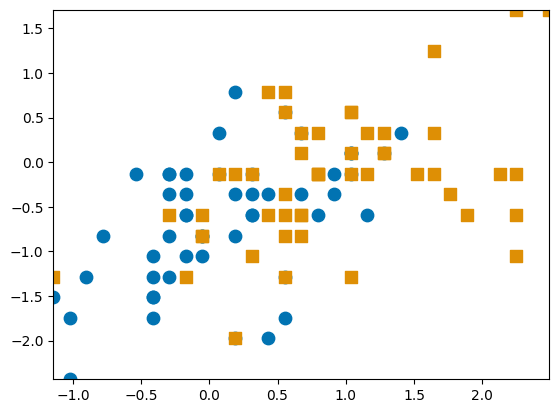

In [6]:
plot_2d(X, y, w=None, alpha_choice=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20)

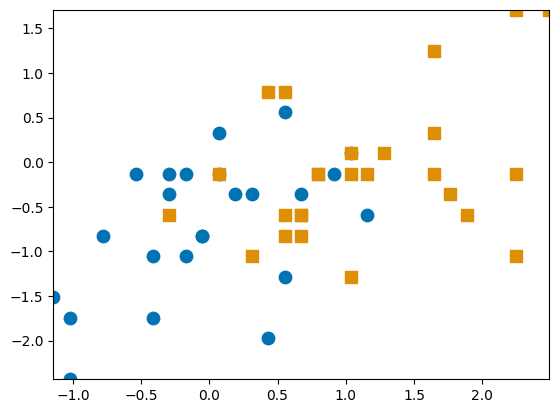

In [8]:
# Données d'apprentissage
plot_2d(X_train, y_train, w=None, alpha_choice=1)

➤ <b>Noyau linéaire :</b>

In [9]:
# classifieur (Noyau linéaire)
svm_classifier_linear = SVC(C=1.0, kernel='linear', probability=True)
svm_classifier_linear.fit(X_train, y_train)
print("Performance du modèle = "+str(round(svm_classifier_linear.score(X_test, y_test),5)))

Performance du modèle = 0.66


In [10]:
# Precision, Recall, F1-score
metrics = precision_recall_fscore_support(y_test, svm_classifier_linear.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2']))

Métrique      Classe 1    Classe 2
----------  ----------  ----------
Precision     0.655172    0.666667
Recall        0.730769    0.583333
F1-score      0.690909    0.622222
Support      26          24


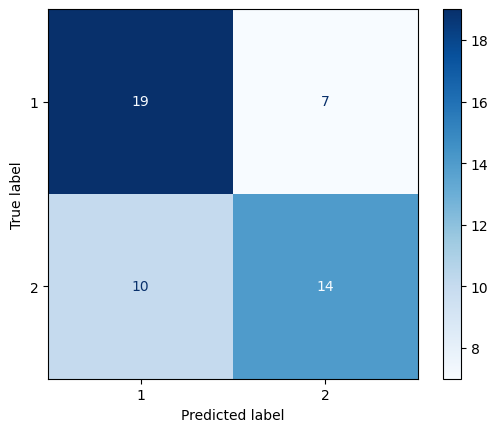

In [11]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm_classifier_linear, X_test, y_test, cmap=plt.cm.Blues)

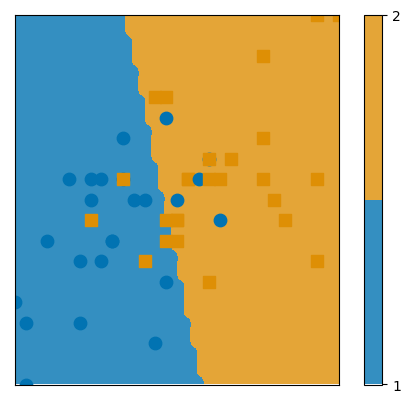

In [12]:
# Frontière de décision
def f_(X):
    return svm_classifier_linear.predict(X)

frontiere(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

<i>Frontière de décision avec les vecteurs de support :</i>

Equation de la droite de décision :

$$ {w}^{T}.x + b = {w}_{1}.{x}_{1} + {w}_{2}.{x}_{2} + b = 0 $$

On peut donc écrire ${x}_{2}$ en fonction de ${x}_{1}$ pour tracer la droite de décision :

$$ {x}_{2} = -\frac{{w}_{1}}{{w}_{2}}.{x}_{1} - \frac{b}{{w}_{2}} $$

Equations des vecteurs supports :

$$ {w}^{T}.x + b = {w}_{1}.{x}_{1} + {w}_{2}.{x}_{2} + b = 1 $$

$$ {w}^{T}.x + b = {w}_{1}.{x}_{1} + {w}_{2}.{x}_{2} + b = -1 $$

Donc :

$$ {x}_{2} = -\frac{{w}_{1}}{{w}_{2}}.{x}_{1} - \frac{b}{{w}_{2}} - \frac{1}{{w}_{2}} $$

$$ {x}_{2} = -\frac{{w}_{1}}{{w}_{2}}.{x}_{1} - \frac{b}{{w}_{2}} + \frac{1}{{w}_{2}} $$

In [13]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 500)
    y = np.linspace(ylim[0], ylim[1], 500)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.pcolormesh(X, Y, P > 0, color=["#F8A3A3","#FDFFD2"], alpha=0.02)
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.6,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', color='g', 
                   label="Vecteurs de supports ou points mal classés (αi > 0)");
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [14]:
train_classe_1 = np.argwhere(y_train == 1).flatten().tolist()
train_classe_2 = np.argwhere(y_train == 2).flatten().tolist()
test_classe_1 = np.argwhere(y_test == 1).flatten().tolist()
test_classe_2 = np.argwhere(y_test == 2).flatten().tolist()

Dans un premier temps, on affiche uniquement les données d'entrainement :

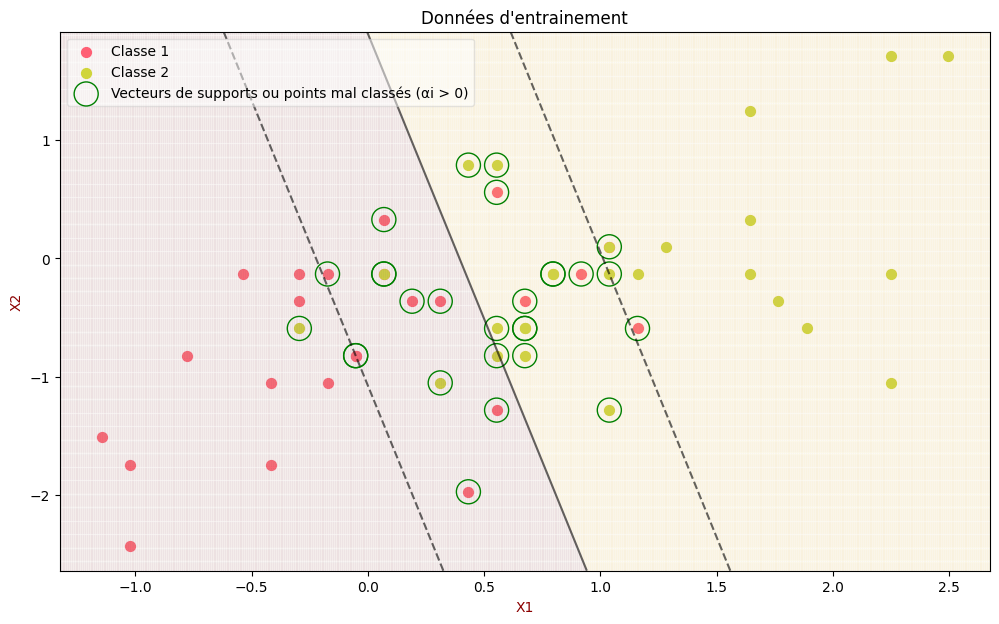

In [15]:
plt.figure(figsize=(12, 7))

plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")

plot_svc_decision_function(svm_classifier_linear, plot_support=True)
plt.title("Données d'entrainement")
plt.xlabel("X1", color='darkred')
plt.ylabel("X2", color='darkred')
plt.legend(loc="upper left", framealpha=0.5)

Ensuite, on ajoute les données de test :

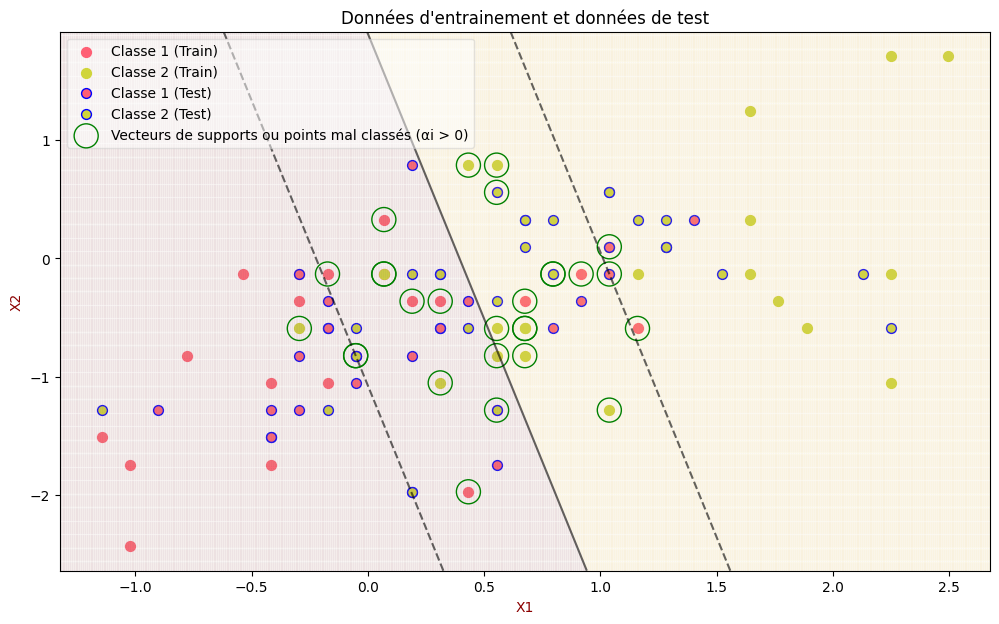

In [16]:
plt.figure(figsize=(12, 7))

plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1 (Train)")
plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2 (Train)")

plt.scatter(X_test[test_classe_1,0], X_test[test_classe_1,1], c="#FF5F74", edgecolors='b', s=50, label="Classe 1 (Test)")
plt.scatter(X_test[test_classe_2,0], X_test[test_classe_2,1], c="#D0D53A", edgecolors='b', s=50, label="Classe 2 (Test)")

plot_svc_decision_function(svm_classifier_linear, plot_support=True)
plt.title("Données d'entrainement et données de test")
plt.xlabel("X1", color='darkred')
plt.ylabel("X2", color='darkred')
plt.legend(loc="upper left", framealpha=0.5)

En utilisant les formules en haut, on obtient le même graphe :

In [17]:
b = svm_classifier_linear.intercept_
w = svm_classifier_linear.coef_
w1 = w[0][0]
w2 = w[0][1]

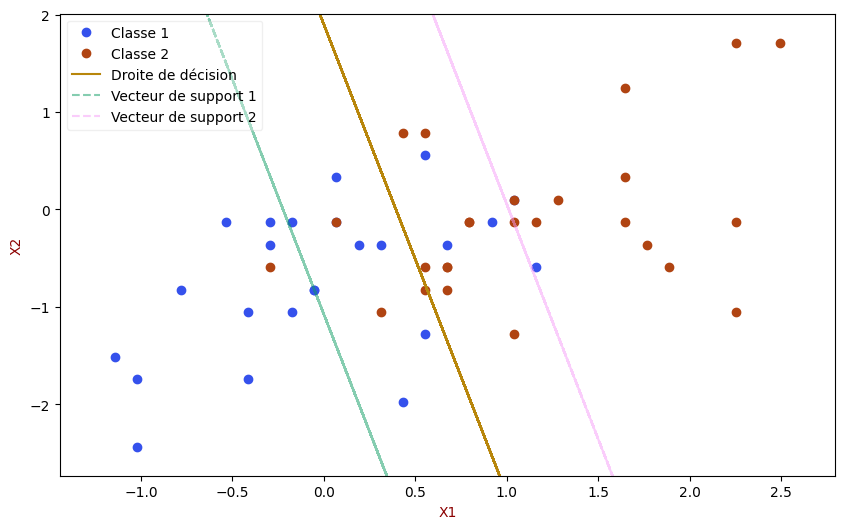

In [18]:
fig = plt.figure(figsize=(10,6))

plt.plot(X_train[train_classe_1,0], X_train[train_classe_1,1], 'o', color="#3551EC", label="Classe 1")
plt.plot(X_train[train_classe_2,0], X_train[train_classe_2,1], 'o', color="#B04412", label="Classe 2")

y_droite = -(w1/w2)*X_train[:,0] - (b/w2)
y_droite_1 = -(w1/w2)*X_train[:,0] - (b/w2) - (1/w2)
y_droite_2 = -(w1/w2)*X_train[:,0] - (b/w2) + (1/w2)

plt.plot(X_train[:,0], y_droite, color='darkgoldenrod', label="Droite de décision")
plt.plot(X_train[:,0], y_droite_1, alpha=0.5, color='#0D9C62', label="Vecteur de support 1", linestyle='--')
plt.plot(X_train[:,0], y_droite_2, alpha=0.5, color='#F79CF9', label="Vecteur de support 2", linestyle='--')

plt.xlim([X_train[:,0].min()-0.3, X_train[:,0].max()+0.3])
plt.ylim([X_train[:,1].min()-0.3, X_train[:,1].max()+0.3])

plt.legend(loc='upper left', framealpha=0.3)
plt.xlabel("X1", color='darkred')
plt.ylabel("X2", color='darkred')

plt.show()

On souhaite maintenant observer l'impact du paramètre de régularisation $C$ sur la marge entre les deux vecteurs de support :

In [19]:
def margin(model):
    w = model.coef_
    margin = 2 / np.sqrt(np.sum(model.coef_**2))
    return margin

In [20]:
margins = []
scores = []
for c in np.linspace(0.05, 3, num=60):
    clf = SVC(C=c, kernel='linear', probability=True)
    clf.fit(X_train, y_train)
    margins.append(margin(clf))
    scores.append(clf.score(X_test, y_test))

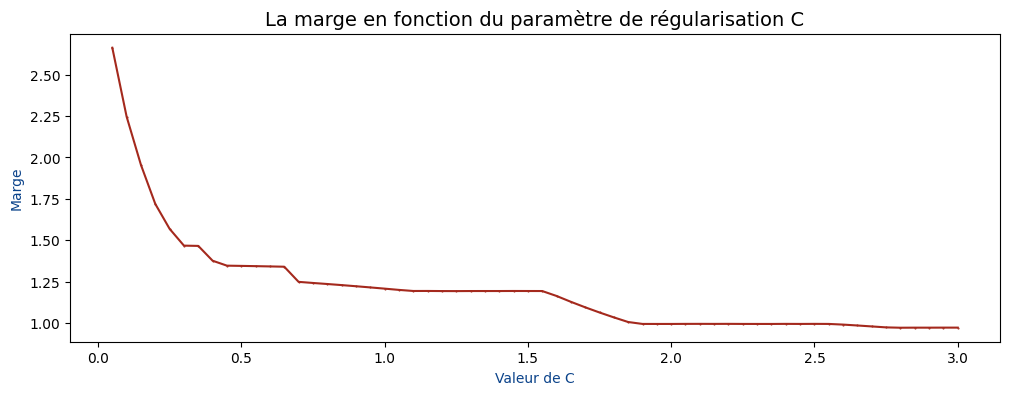

In [21]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 4)
ax.plot(np.linspace(0.05, 3, num=60), margins, marker=".", markersize=1, color="#A4291D")
ax.set_title("La marge en fonction du paramètre de régularisation C", fontsize=14)
ax.set_xlabel("Valeur de C", fontsize=10, color="#0B438A")
ax.set_ylabel("Marge", fontsize=10, color="#0B438A")
plt.show()

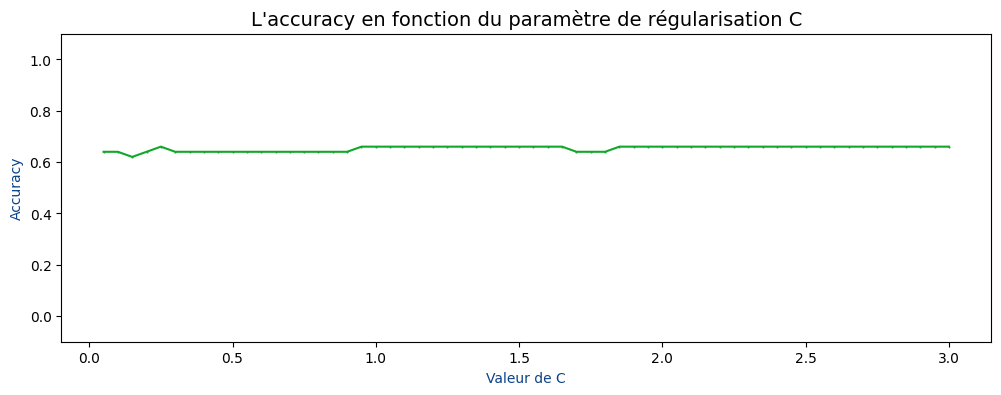

In [22]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 4)
ax.plot(np.linspace(0.05, 3, num=60), scores, marker=".", markersize=1, color="#13A729")
ax.set_title("L'accuracy en fonction du paramètre de régularisation C", fontsize=14)
ax.set_xlabel("Valeur de C", fontsize=10, color="#0B438A")
ax.set_ylabel("Accuracy", fontsize=10, color="#0B438A")
ax.set_ylim([-0.1, 1.1])
plt.show()

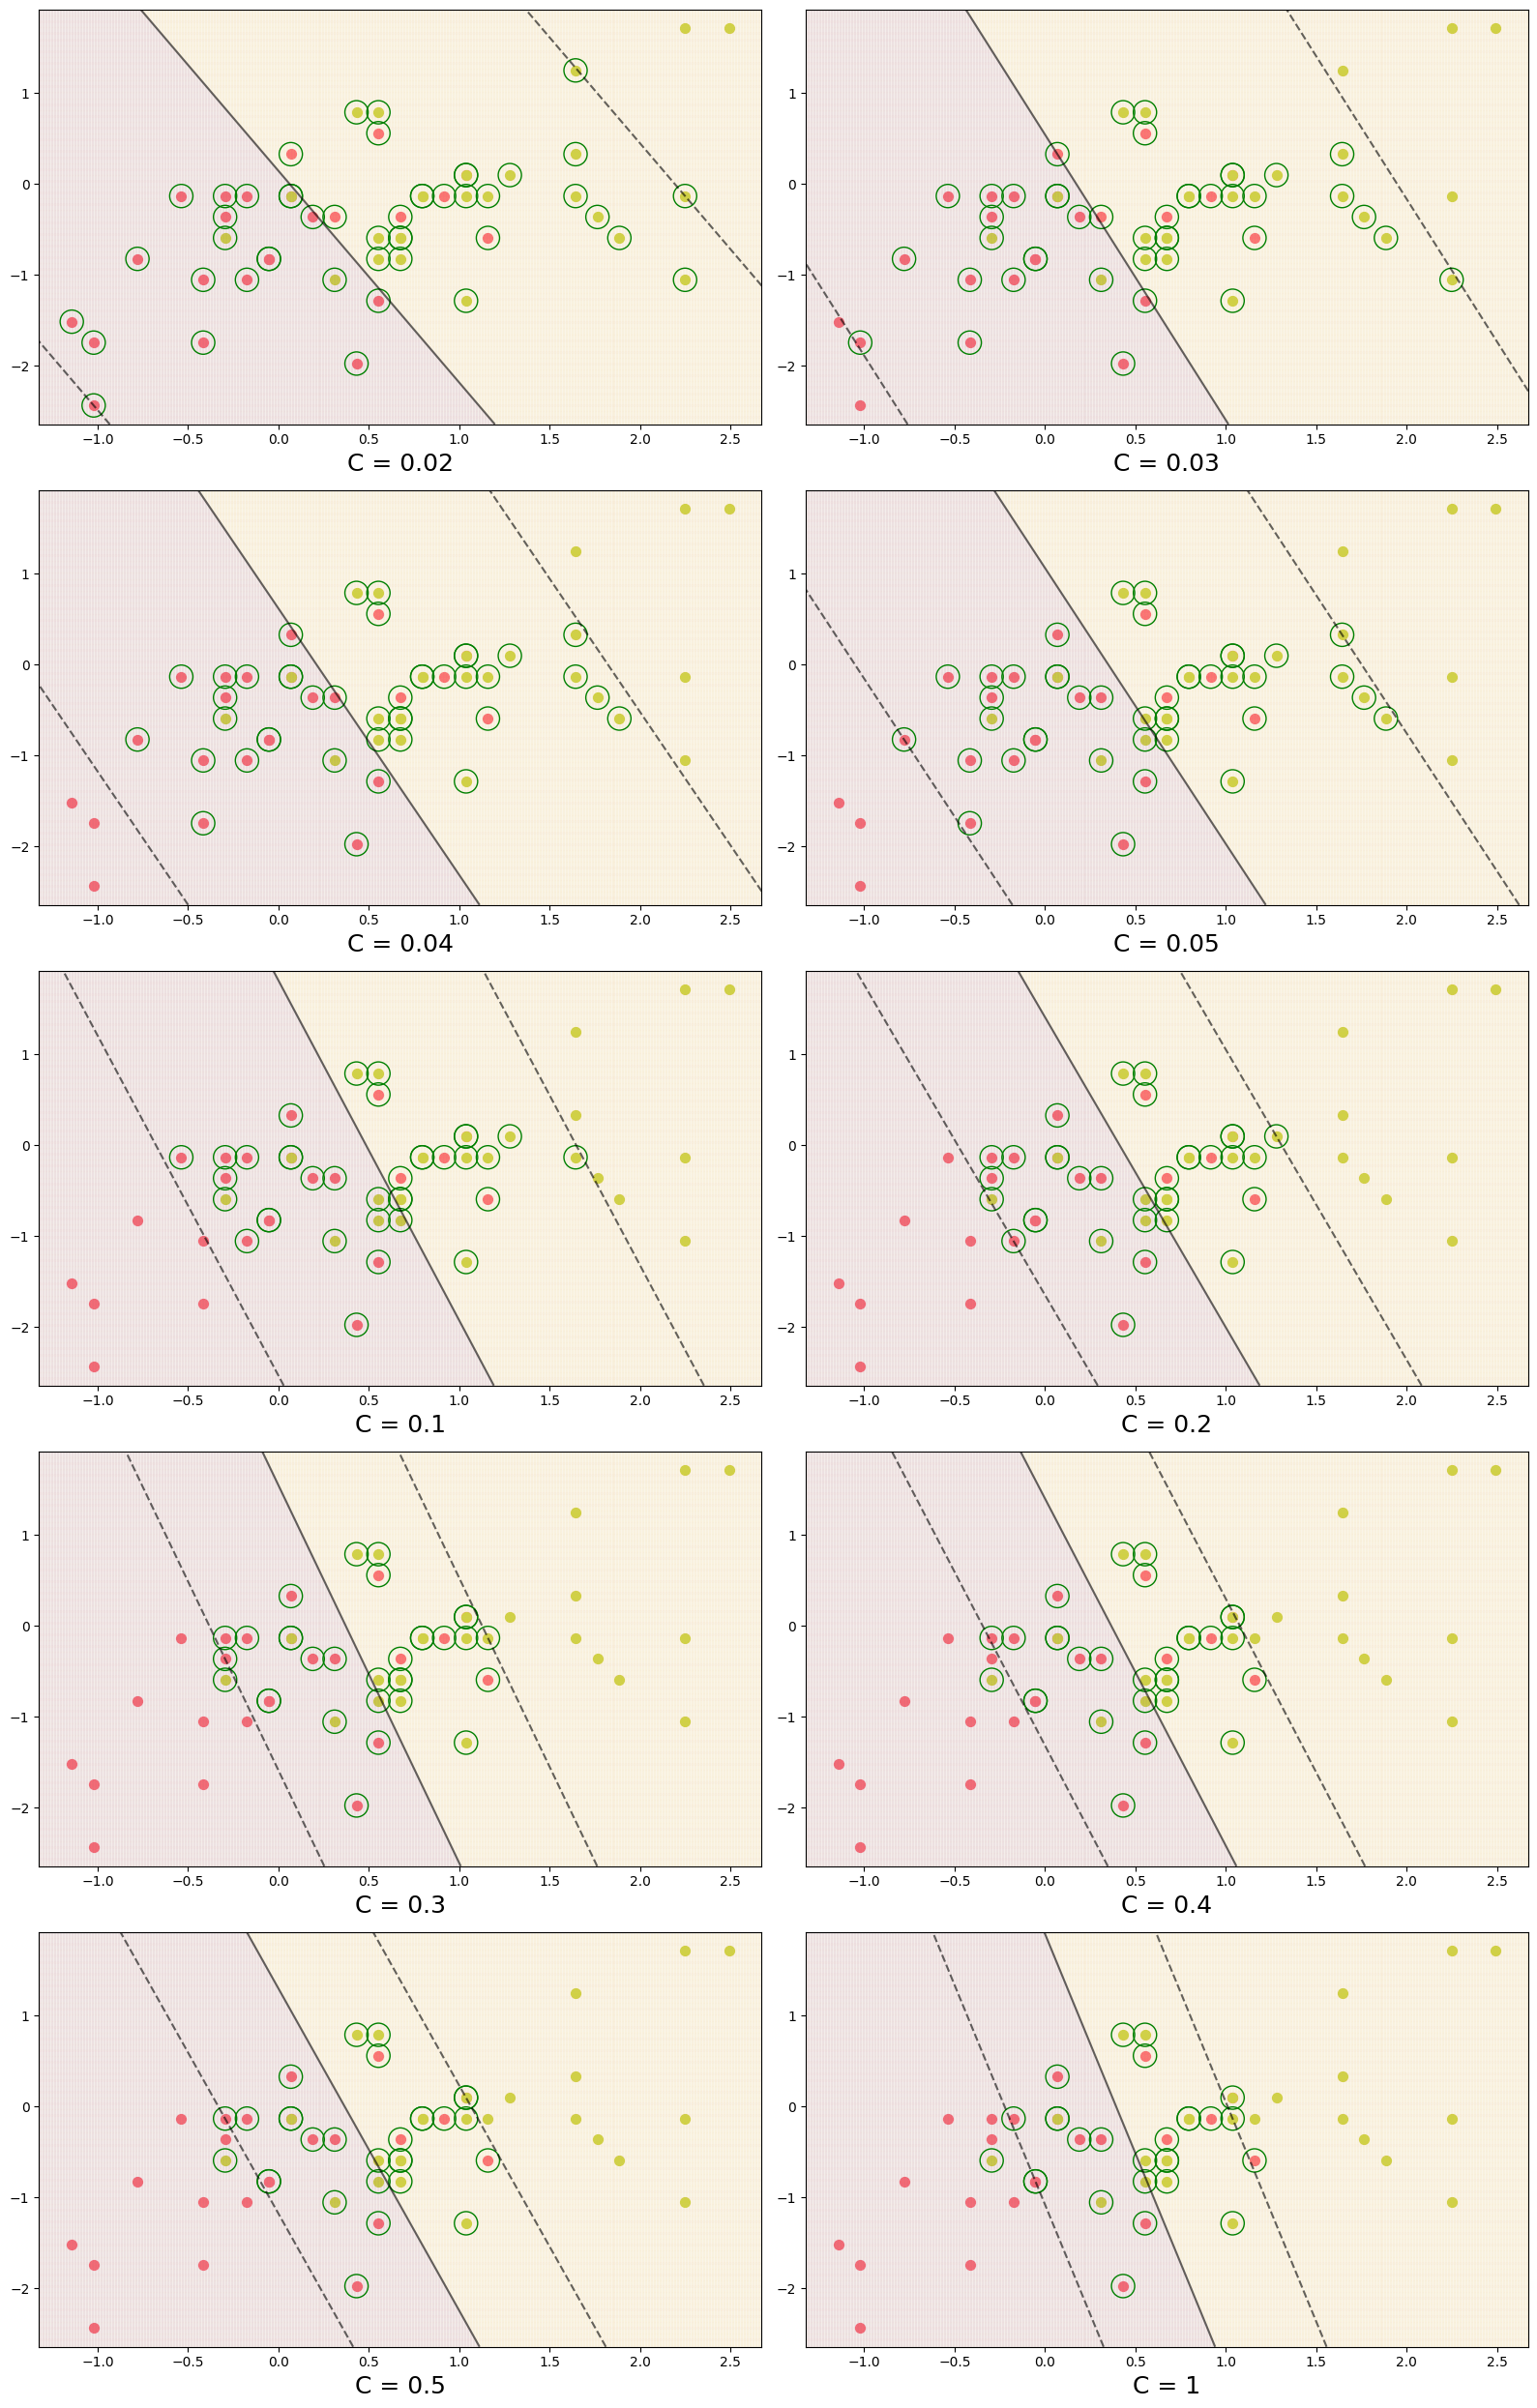

In [23]:
plt.figure(figsize=(16, 25))

for i,c in enumerate([0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]):
    clf = SVC(C=c, kernel='linear', probability=True)
    clf.fit(X_train, y_train)

    plt.subplot(5, 2, i+1)
    plt.xlabel('C = '+str(c), fontsize=18)
    
    plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
    plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")
    plot_svc_decision_function(clf, plot_support=True)
    
plt.tight_layout()

### Question 2 :

➤ <b>Noyau polynomial :</b>

In [24]:
# Classifieur (Noyau polynomial)
svm_classifier_polynomial = SVC(C=1, kernel='poly', degree=3, probability=True)
svm_classifier_polynomial.fit(X_train, y_train)
print("Performance du modèle = "+str(round(svm_classifier_polynomial.score(X_test, y_test),5)))

Performance du modèle = 0.6


In [25]:
# Precision, Recall, F1-score
metrics = precision_recall_fscore_support(y_test, svm_classifier_polynomial.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2']))

Métrique      Classe 1    Classe 2
----------  ----------  ----------
Precision     0.578947    0.666667
Recall        0.846154    0.333333
F1-score      0.6875      0.444444
Support      26          24


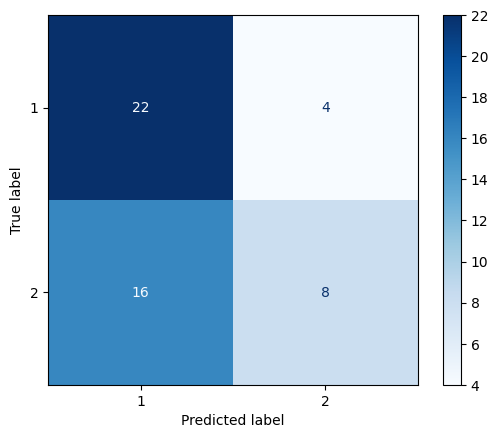

In [26]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm_classifier_polynomial, X_test, y_test, cmap=plt.cm.Blues)

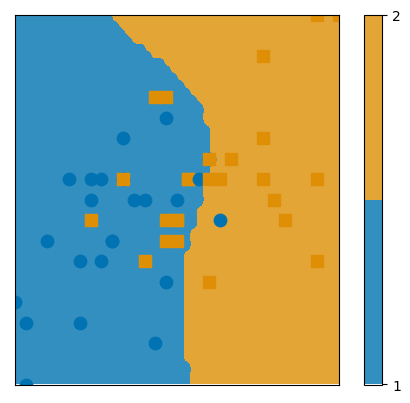

In [27]:
# Frontière de décision
def f_(X):
    return svm_classifier_polynomial.predict(X)

frontiere(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

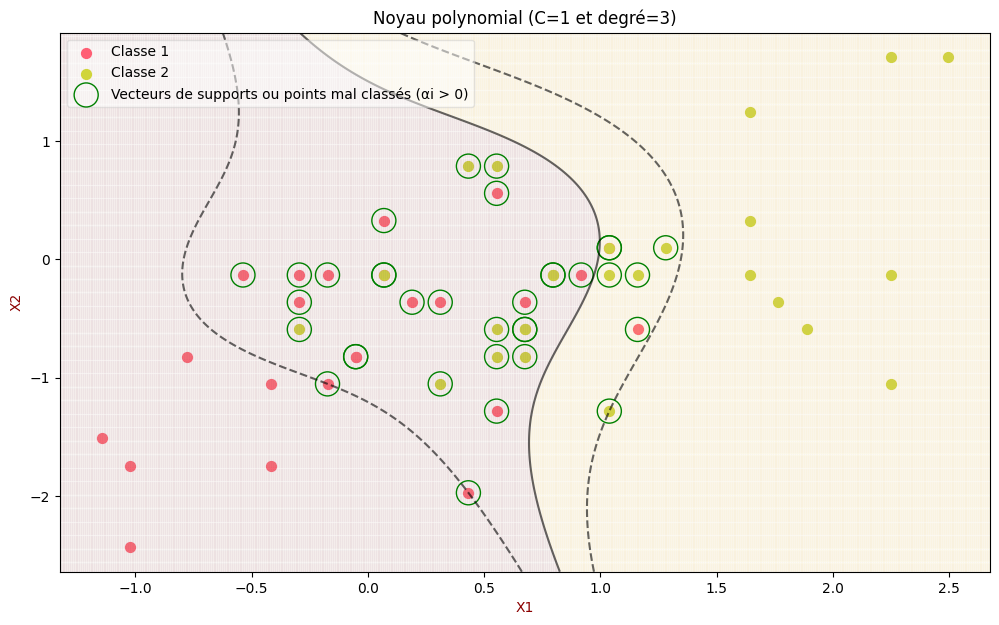

In [28]:
plt.figure(figsize=(12, 7))

plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")

plot_svc_decision_function(svm_classifier_polynomial, plot_support=True)
plt.title("Noyau polynomial (C=1 et degré=3)")
plt.xlabel("X1", color='darkred')
plt.ylabel("X2", color='darkred')
plt.legend(loc="upper left", framealpha=0.5)

In [29]:
scores_1 = []
scores_2 = []
scores_3 = []

for c in np.linspace(0.05, 3, num=60):
    
    clf_1 = SVC(C=c, kernel='poly', degree=1, probability=True)
    clf_1.fit(X_train, y_train)
    scores_1.append(clf_1.score(X_test, y_test))
    
    clf_2 = SVC(C=c, kernel='poly', degree=2, probability=True)
    clf_2.fit(X_train, y_train)
    scores_2.append(clf_2.score(X_test, y_test))
    
    clf_3 = SVC(C=c, kernel='poly', degree=3, probability=True)
    clf_3.fit(X_train, y_train)
    scores_3.append(clf_3.score(X_test, y_test))

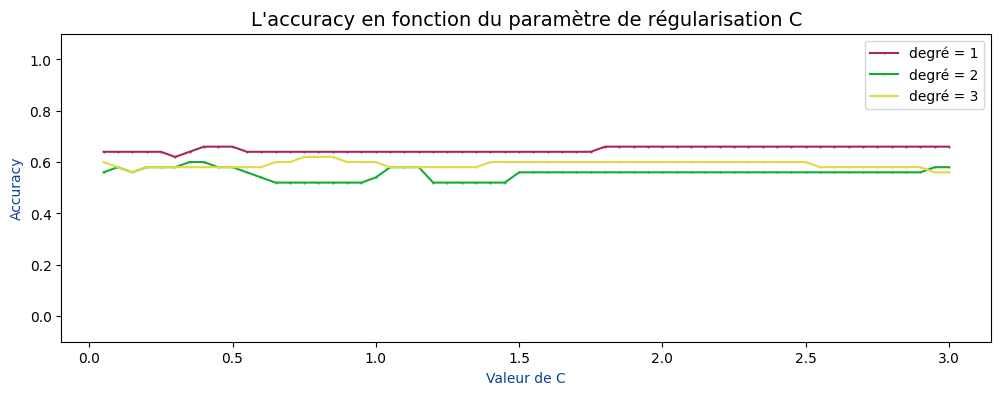

In [30]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 4)
ax.plot(np.linspace(0.05, 3, num=60), scores_1, marker=".", markersize=1, color="#A52762", label="degré = 1")
ax.plot(np.linspace(0.05, 3, num=60), scores_2, marker=".", markersize=1, color="#14AC32", label="degré = 2")
ax.plot(np.linspace(0.05, 3, num=60), scores_3, marker=".", markersize=1, color="#E1DA47", label="degré = 3")
ax.set_title("L'accuracy en fonction du paramètre de régularisation C", fontsize=14)
ax.set_xlabel("Valeur de C", fontsize=10, color="#0B438A")
ax.set_ylabel("Accuracy", fontsize=10, color="#0B438A")
ax.set_ylim([-0.1, 1.1])
ax.legend()
plt.show()

Voyons maintenant l'impact de C sur la marge, pour ces trois valeurs du degré :

● <i>Degré = 1 :</i>

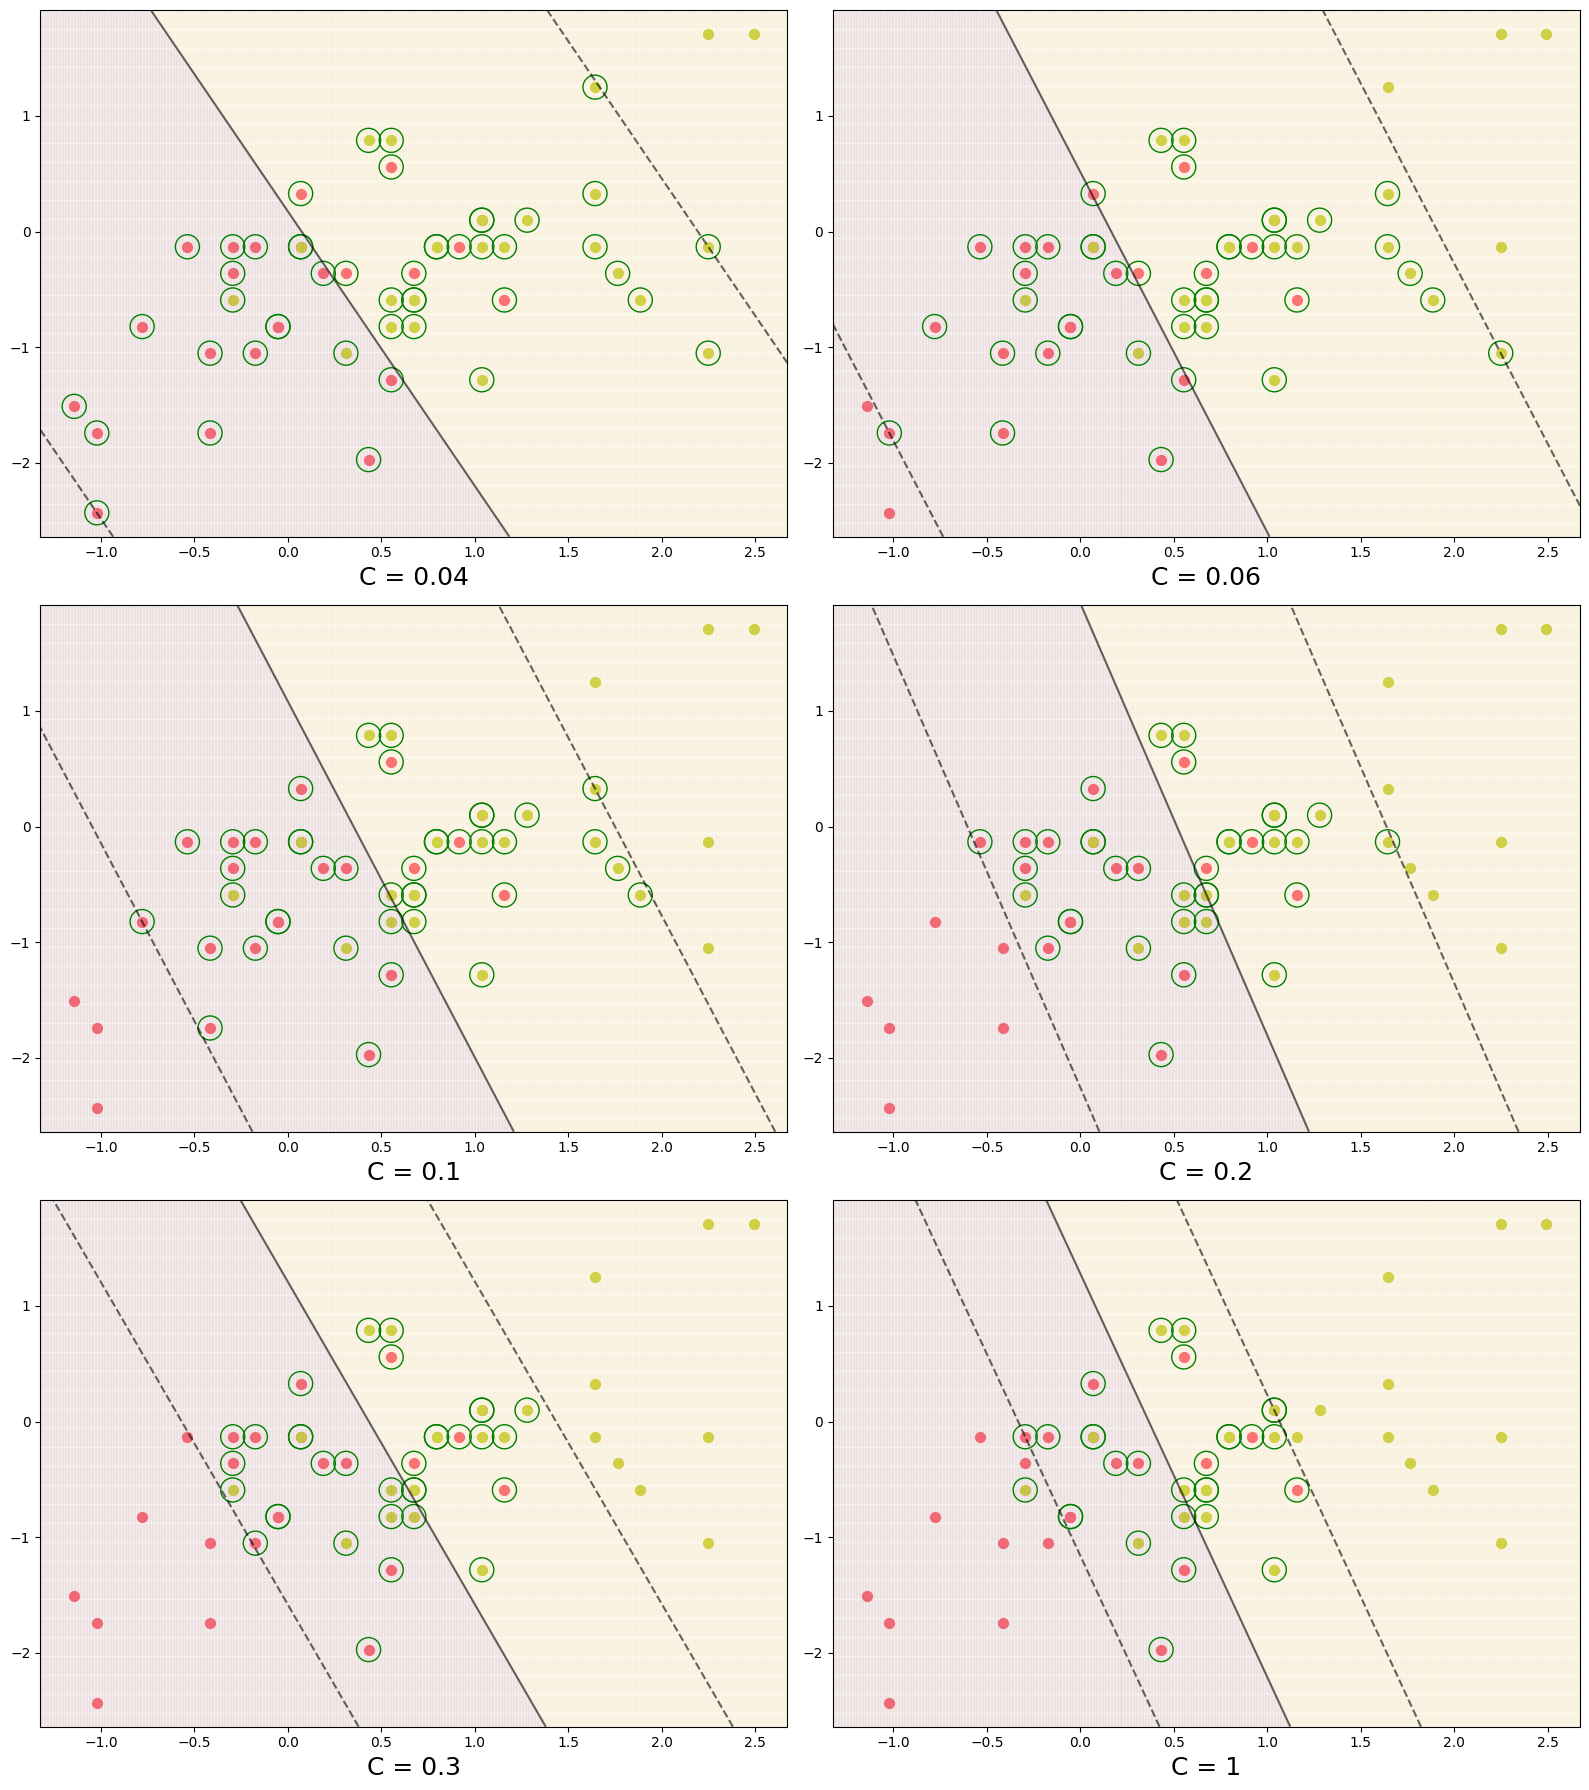

In [31]:
plt.figure(figsize=(16, 18))

for i,c in enumerate([0.04, 0.06, 0.1, 0.2, 0.3, 1]):
    clf = SVC(C=c, kernel='poly', degree=1, probability=True)
    clf.fit(X_train, y_train)

    plt.subplot(3, 2, i+1)
    plt.xlabel('C = '+str(c), fontsize=18)
    
    plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
    plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")
    plot_svc_decision_function(clf, plot_support=True)
    
plt.tight_layout()

● <i>Degré = 2 :</i>

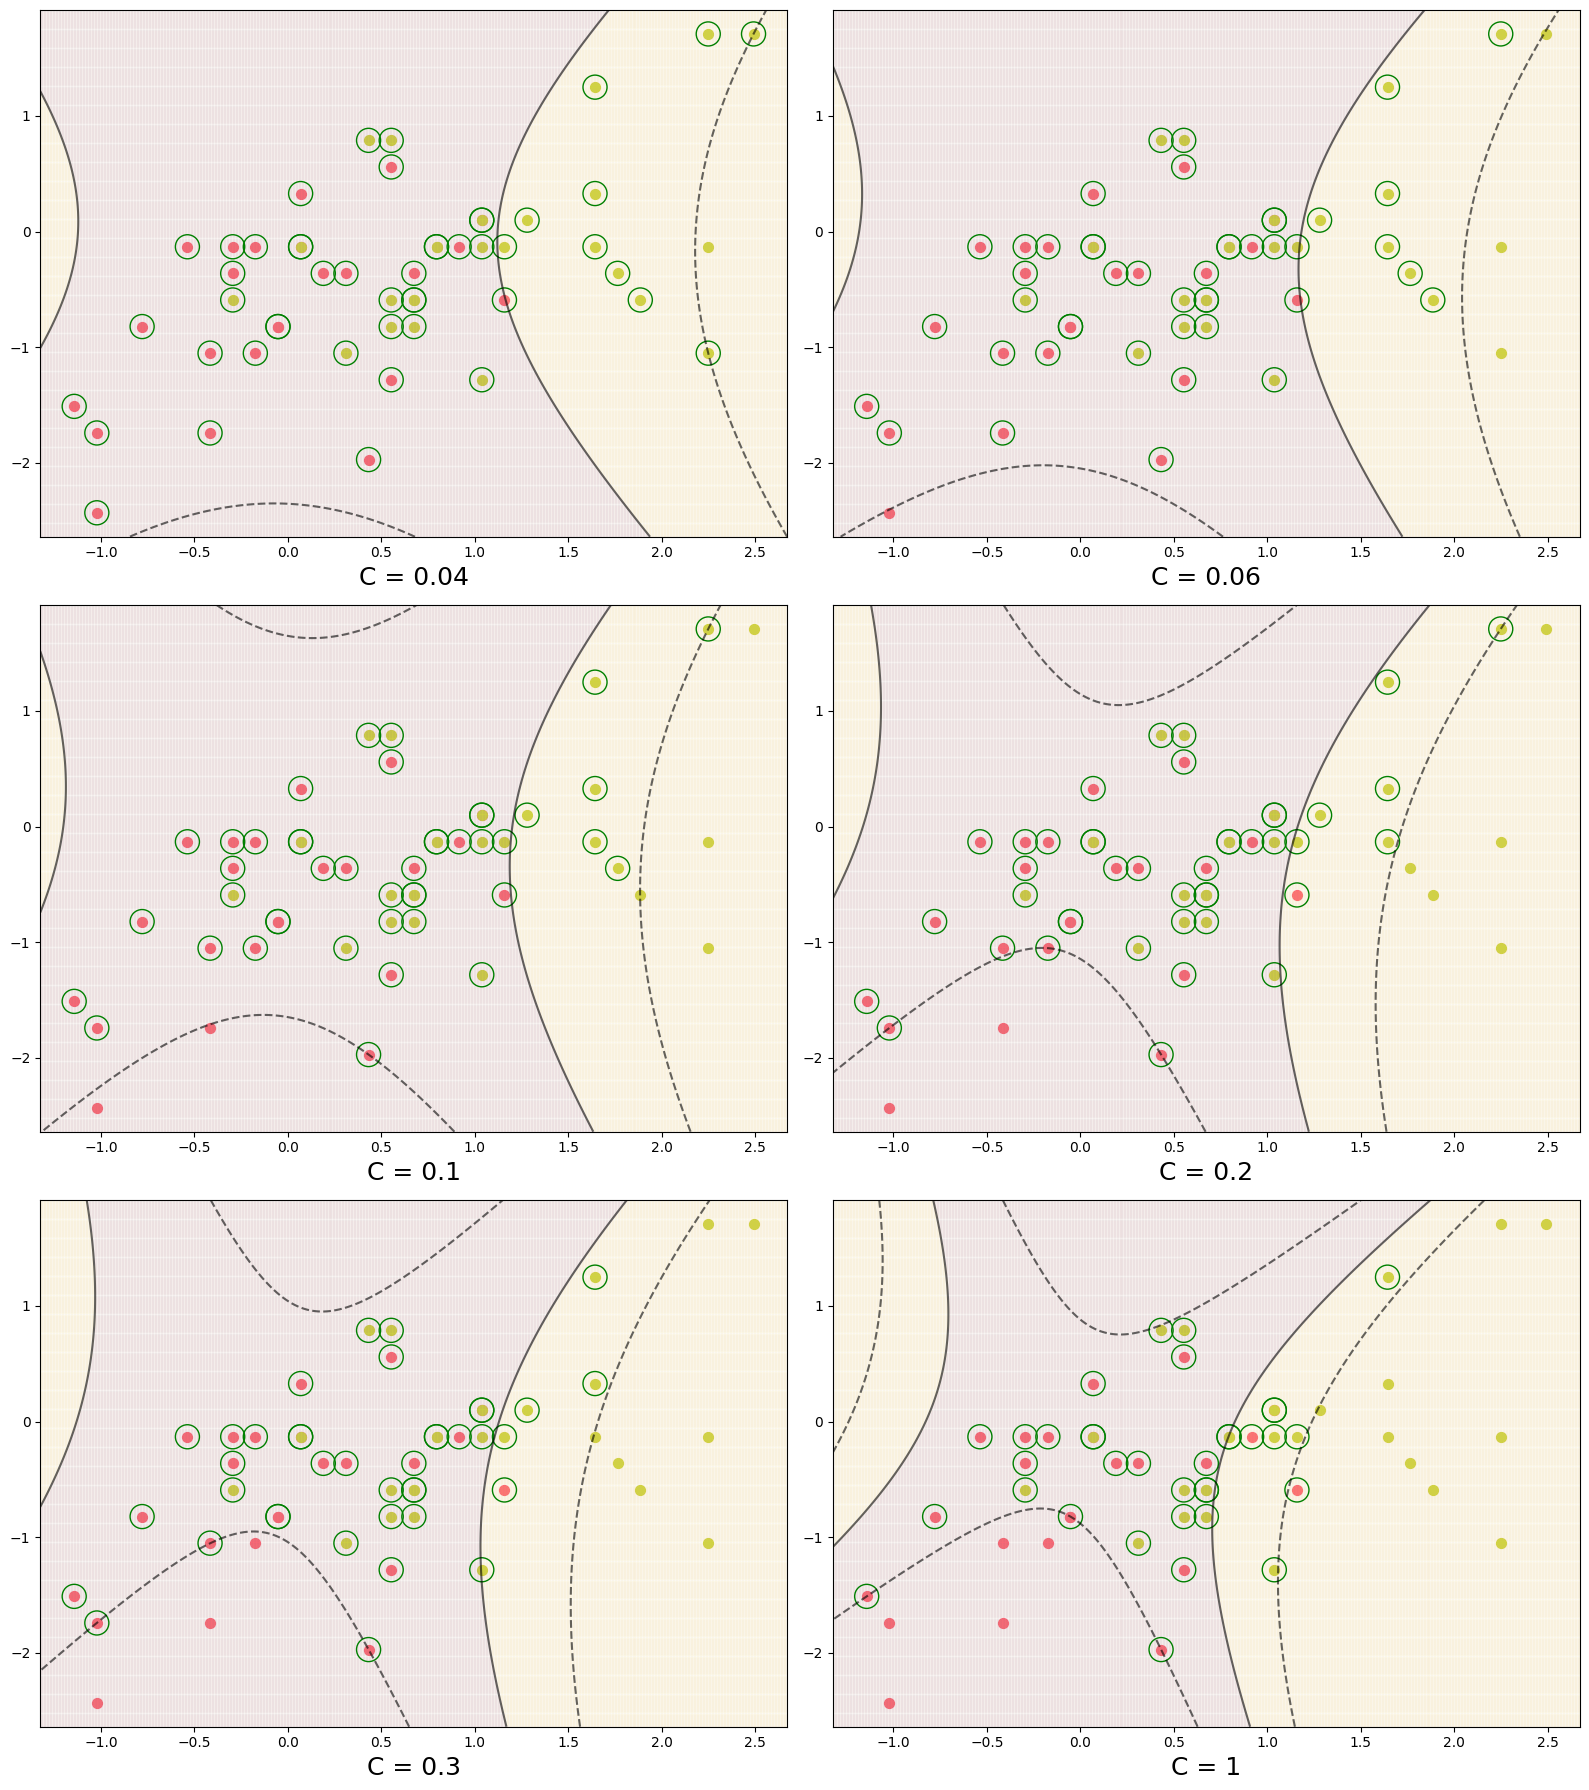

In [32]:
plt.figure(figsize=(16, 18))

for i,c in enumerate([0.04, 0.06, 0.1, 0.2, 0.3, 1]):
    clf = SVC(C=c, kernel='poly', degree=2, probability=True)
    clf.fit(X_train, y_train)

    plt.subplot(3, 2, i+1)
    plt.xlabel('C = '+str(c), fontsize=18)
    
    plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
    plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")
    plot_svc_decision_function(clf, plot_support=True)
    
plt.tight_layout()

● <i>Degré = 3 :</i>

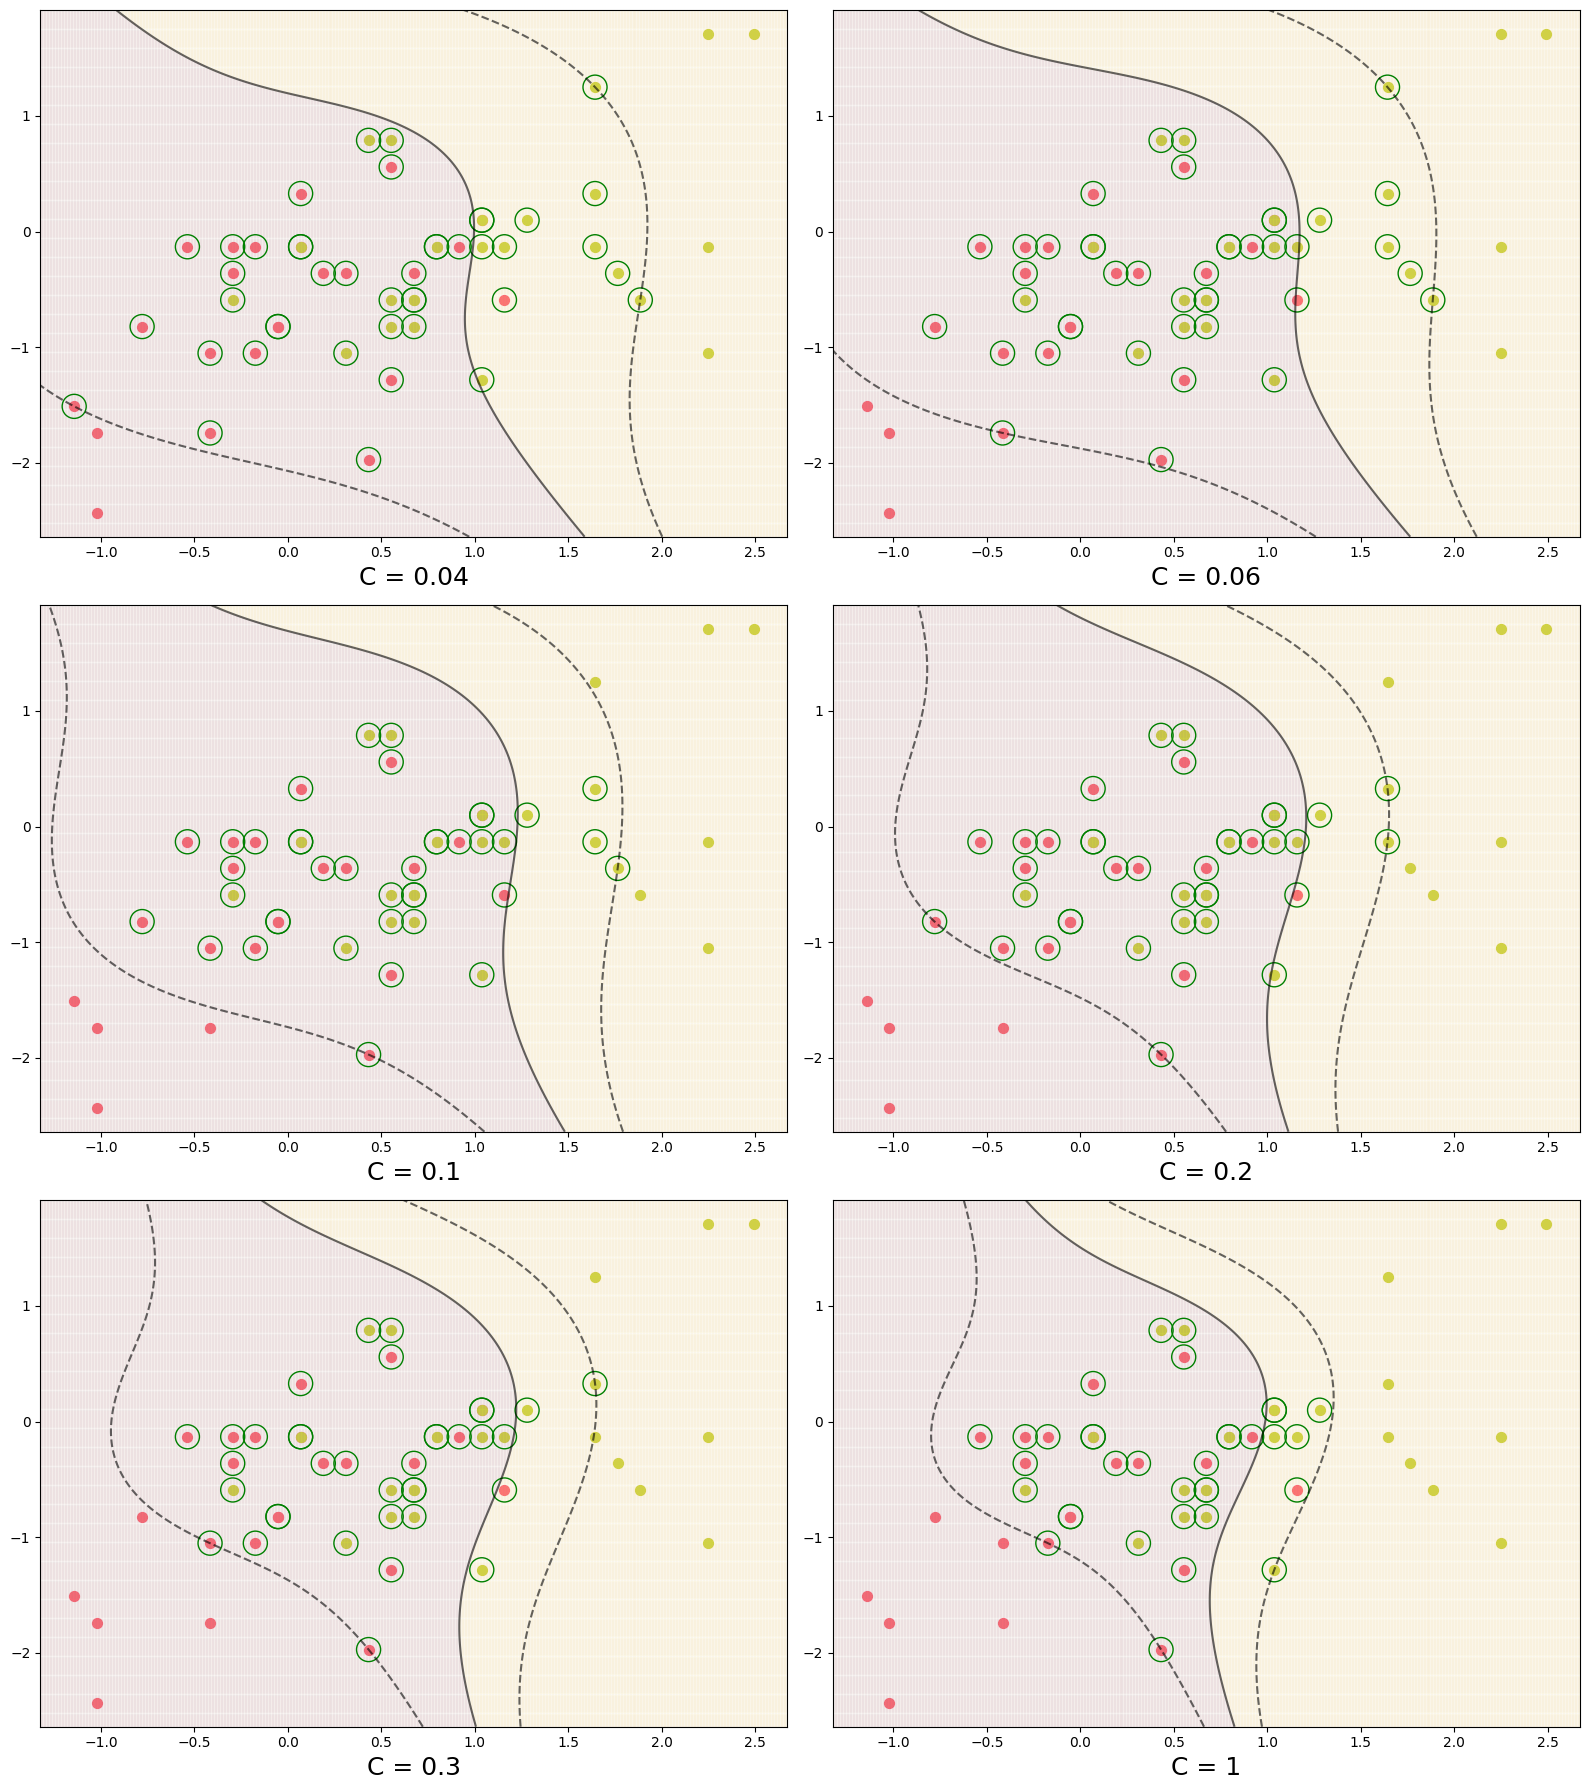

In [33]:
plt.figure(figsize=(16, 18))

for i,c in enumerate([0.04, 0.06, 0.1, 0.2, 0.3, 1]):
    clf = SVC(C=c, kernel='poly', degree=3, probability=True)
    clf.fit(X_train, y_train)

    plt.subplot(3, 2, i+1)
    plt.xlabel('C = '+str(c), fontsize=18)
    
    plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
    plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")
    plot_svc_decision_function(clf, plot_support=True)
    
plt.tight_layout()

➤ <b>Noyau RBF :</b>

In [34]:
# Classifieur (Noyau RBF)
svm_classifier_rbf = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True)
svm_classifier_rbf.fit(X_train, y_train)
print("Performance du modèle = "+str(round(svm_classifier_rbf.score(X_test, y_test),5)))

Performance du modèle = 0.66


In [35]:
# Precision, Recall, F1-score
metrics = precision_recall_fscore_support(y_test, svm_classifier_rbf.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2']))

Métrique      Classe 1    Classe 2
----------  ----------  ----------
Precision     0.68        0.64
Recall        0.653846    0.666667
F1-score      0.666667    0.653061
Support      26          24


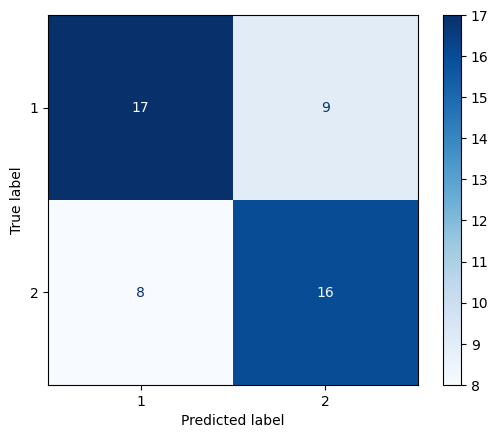

In [36]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm_classifier_rbf, X_test, y_test, cmap=plt.cm.Blues)

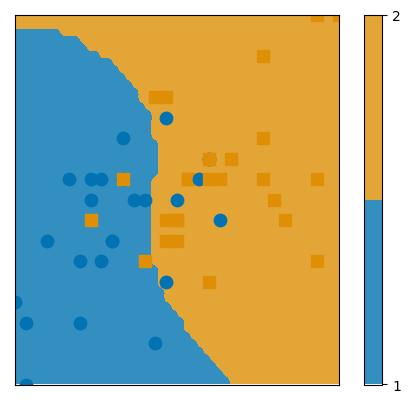

In [37]:
# Frontière de décision
def f_(X):
    return svm_classifier_rbf.predict(X)

frontiere(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

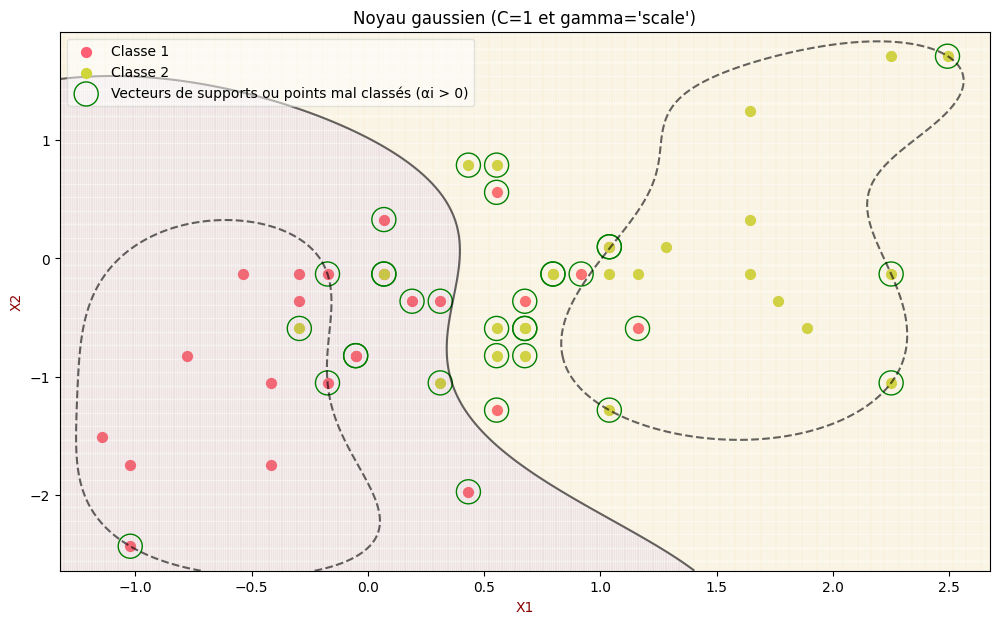

In [38]:
plt.figure(figsize=(12, 7))

plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")

plot_svc_decision_function(svm_classifier_rbf, plot_support=True)
plt.title("Noyau gaussien (C=1 et gamma='scale')")
plt.xlabel("X1", color='darkred')
plt.ylabel("X2", color='darkred')
plt.legend(loc="upper left", framealpha=0.5)

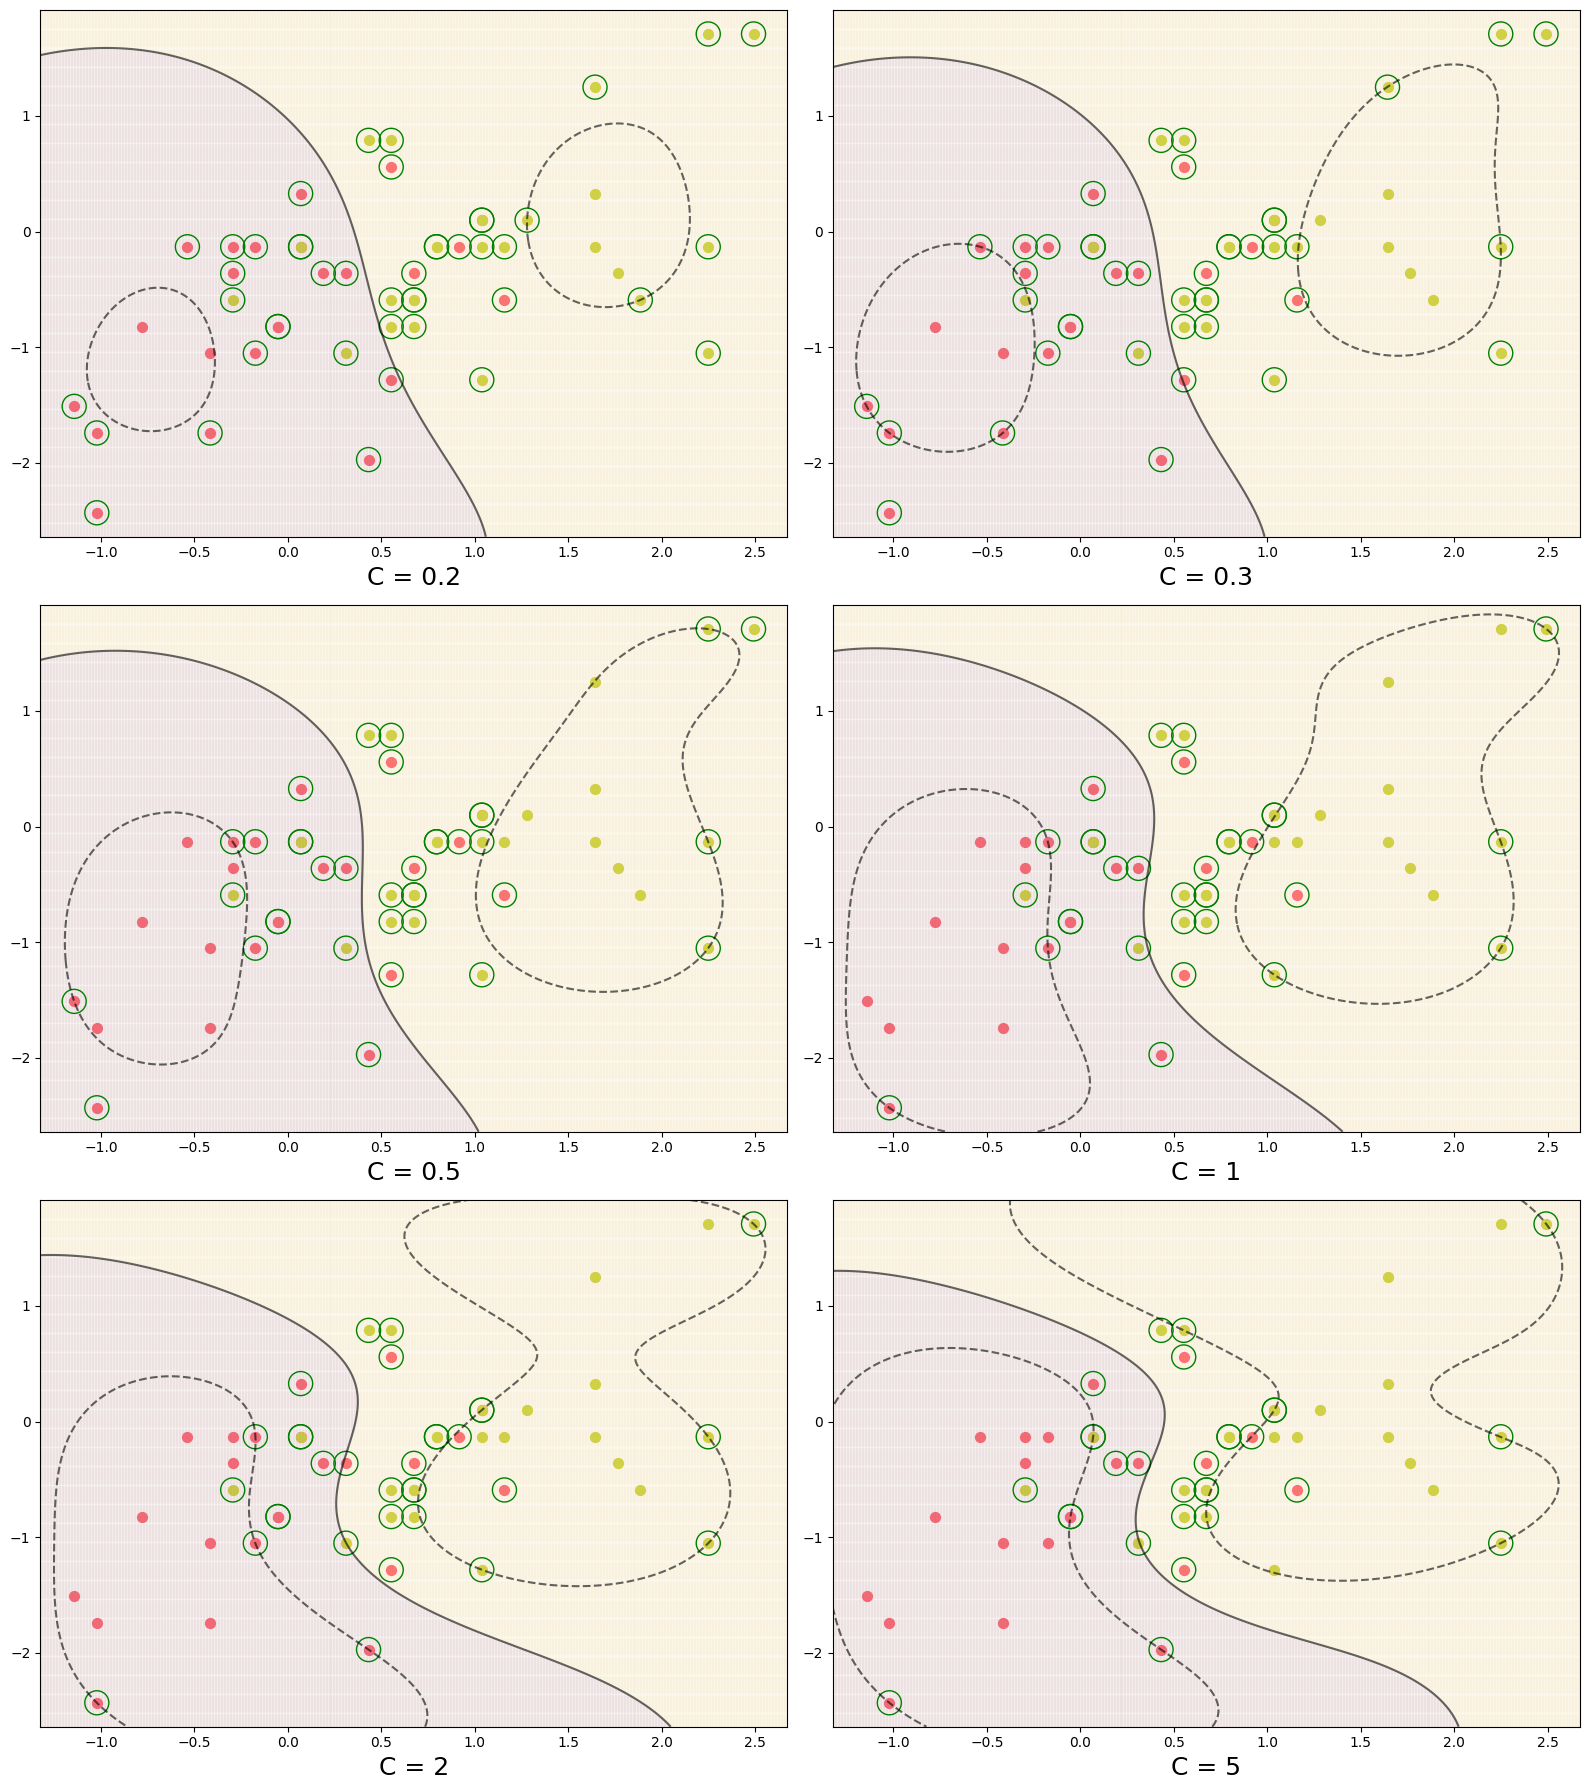

In [39]:
plt.figure(figsize=(16, 18))

for i,c in enumerate([0.2, 0.3, 0.5, 1, 2, 5]):
    clf = SVC(C=c, kernel='rbf', gamma='scale', probability=True)
    clf.fit(X_train, y_train)

    plt.subplot(3, 2, i+1)
    plt.xlabel('C = '+str(c), fontsize=18)
    
    plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
    plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")
    plot_svc_decision_function(clf, plot_support=True)
    
plt.tight_layout()

➤ <b>Comparaisons :</b>

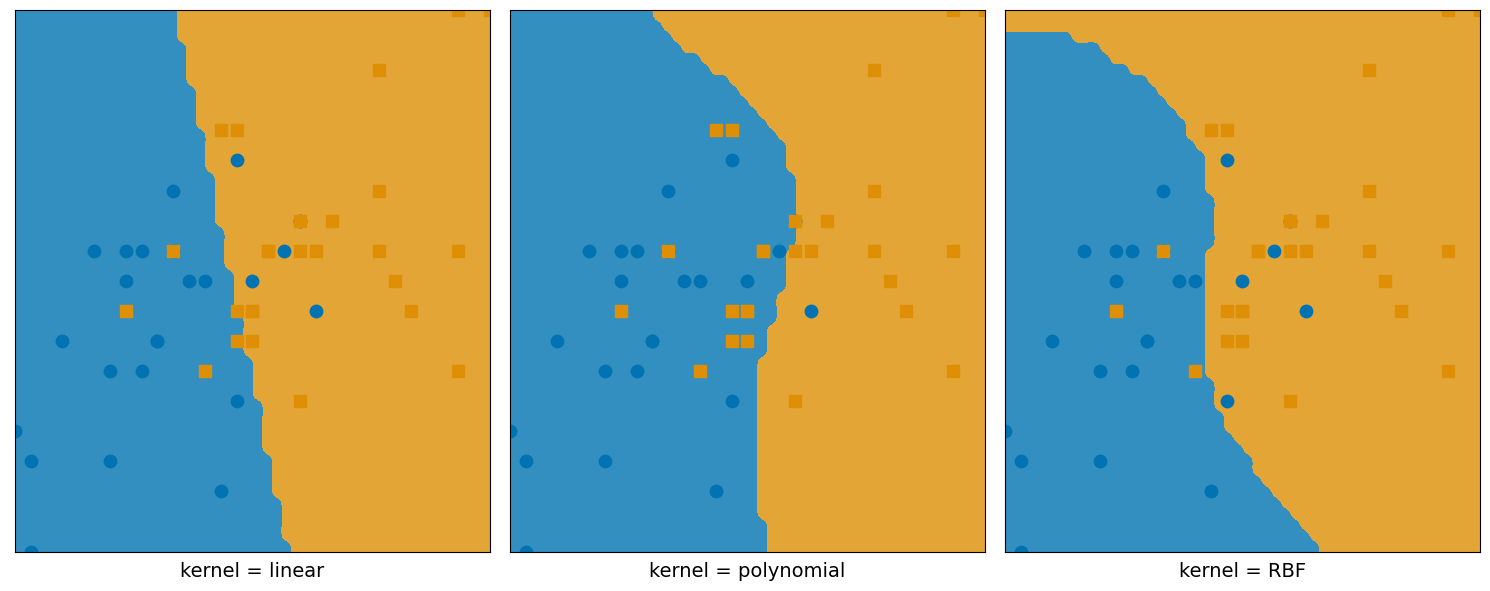

In [40]:
plt.figure(figsize=(15, 10))
svm_classifiers = [svm_classifier_linear, svm_classifier_polynomial, svm_classifier_rbf]
kernels = ['linear', 'polynomial', 'RBF']

for i in range(3):
    
    svm = svm_classifiers[i]
    
    def f_(X):
        return svm.predict(X)
    
    plt.subplot(1, 3, i+1)
    plt.xlabel('kernel = '+str(kernels[i]), fontsize=14)
    frontiere(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

plt.tight_layout()

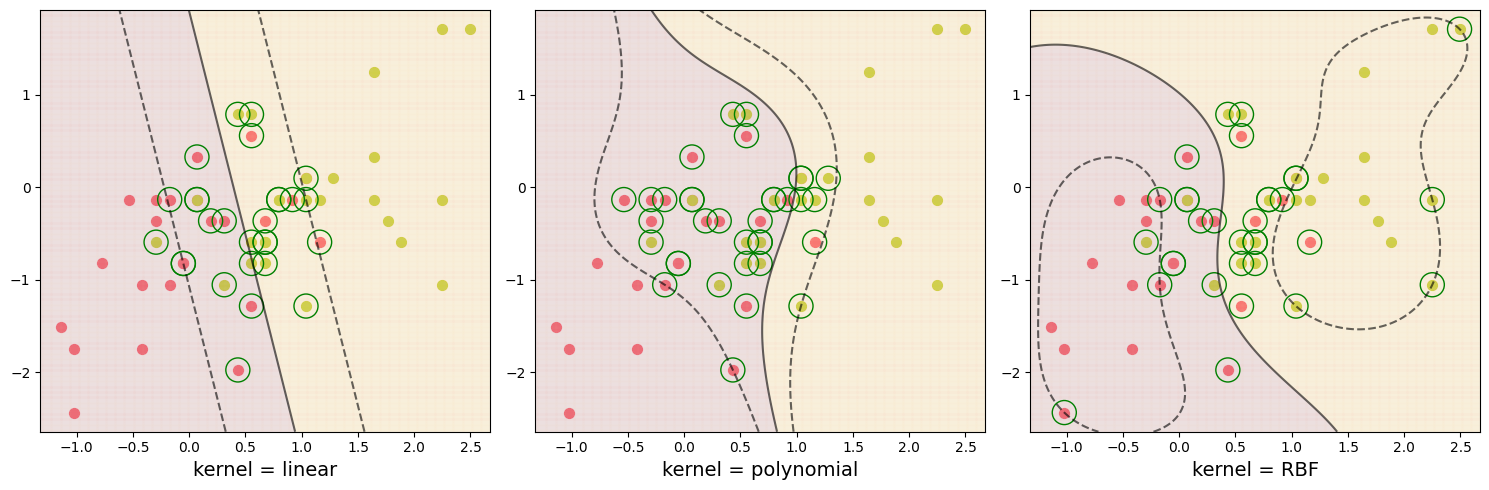

In [41]:
plt.figure(figsize=(15, 5))
svm_classifiers = [svm_classifier_linear, svm_classifier_polynomial, svm_classifier_rbf]
kernels = ['linear', 'polynomial', 'RBF']

for i in range(3):
    
    svm = svm_classifiers[i]

    plt.subplot(1, 3, i+1)
    plt.xlabel('kernel = '+str(kernels[i]), fontsize=14)
    plt.scatter(X_train[train_classe_1,0], X_train[train_classe_1,1], c="#FF5F74", s=50, label="Classe 1")
    plt.scatter(X_train[train_classe_2,0], X_train[train_classe_2,1], c="#D0D53A", s=50, label="Classe 2")
    plot_svc_decision_function(svm, plot_support=True)

plt.tight_layout()

➤ <b>Courbes ROC <i>(ROC curve)</i> :</b>

Dans ce qui suit, on considère que la classe $2$ est la classe $+$, et la classe $1$ est la classe $-$.

In [42]:
# Probability of belonging to the positive class (class 2)
y_pred_proba_lin = svm_classifier_linear.predict_proba(X_test)[:,1]
y_pred_proba_poly = svm_classifier_polynomial.predict_proba(X_test)[:,1]
y_pred_proba_rbf = svm_classifier_rbf.predict_proba(X_test)[:,1]

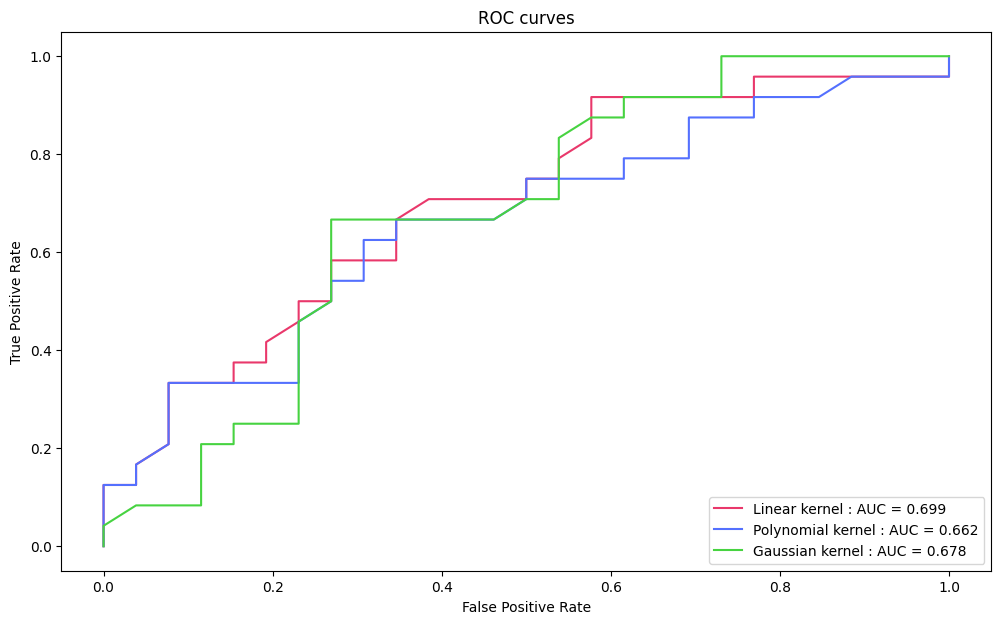

In [43]:
# False Positives Rate and True Positives Rate
fpr_lin, tpr_lin, _ = roc_curve(y_test, y_pred_proba_lin, pos_label=2)
fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_proba_poly, pos_label=2)
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_proba_rbf, pos_label=2)

# AUC area (the area under the ROC curve as a %)
auc_lin = roc_auc_score(y_test, y_pred_proba_lin)
auc_poly = roc_auc_score(y_test, y_pred_proba_poly)
auc_rbf = roc_auc_score(y_test, y_pred_proba_rbf)

# ROC curve
plt.figure(figsize=(12, 7))
plt.plot(fpr_lin, tpr_lin, color="#E9386B", label="Linear kernel : AUC = "+str(round(auc_lin,3)))
plt.plot(fpr_poly, tpr_poly, color="#5470FE", label="Polynomial kernel : AUC = "+str(round(auc_poly,3)))
plt.plot(fpr_rbf, tpr_rbf, color="#47D341", label="Gaussian kernel : AUC = "+str(round(auc_rbf,3)))
plt.title("ROC curves")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

➤ <b>Courbes Précision-Rappel <i>(PR curve)</i> :</b>

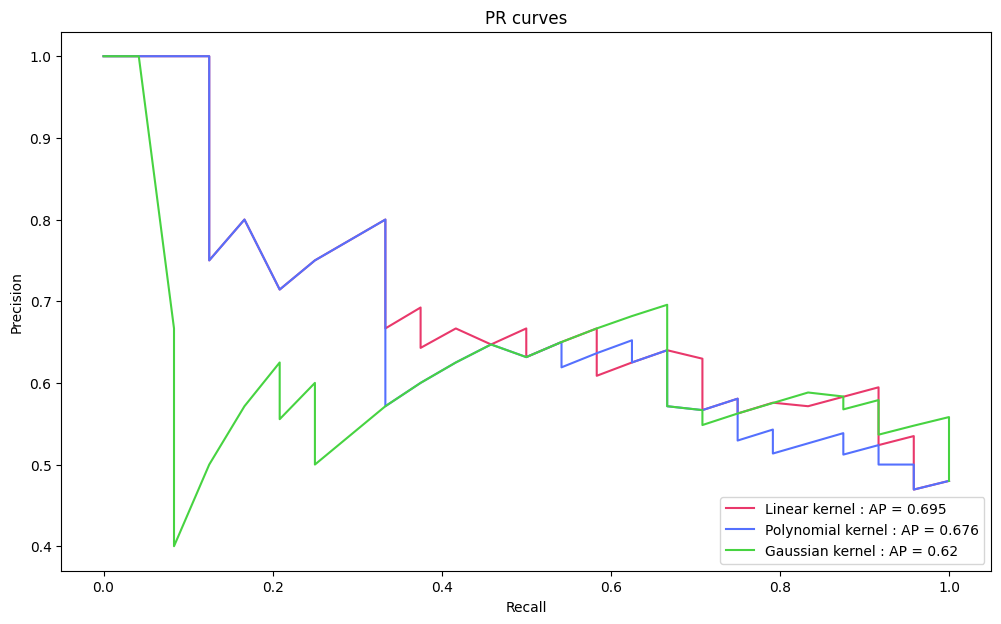

In [44]:
# Precision and Recall
precision_lin, recall_lin, _ = precision_recall_curve(y_test, y_pred_proba_lin, pos_label=2)
precision_poly, recall_poly, _ = precision_recall_curve(y_test, y_pred_proba_poly, pos_label=2)
precision_rbf, recall_rbf, _ = precision_recall_curve(y_test, y_pred_proba_rbf, pos_label=2)

# Average precision scores
AP_lin = average_precision_score(y_test, y_pred_proba_lin, pos_label=2)
AP_poly = average_precision_score(y_test, y_pred_proba_poly, pos_label=2)
AP_rbf = average_precision_score(y_test, y_pred_proba_rbf, pos_label=2)

# PR curve
plt.figure(figsize=(12, 7))
plt.plot(recall_lin, precision_lin, color="#E9386B", label="Linear kernel : AP = "+str(round(AP_lin,3)))
plt.plot(recall_poly, precision_poly, color="#5470FE", label="Polynomial kernel : AP = "+str(round(AP_poly,3)))
plt.plot(recall_rbf, precision_rbf, color="#47D341", label="Gaussian kernel : AP = "+str(round(AP_rbf,3)))
plt.title("PR curves")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

➤ <b>Courbes d'apprentissage <i>(Learning curve)</i> :</b>

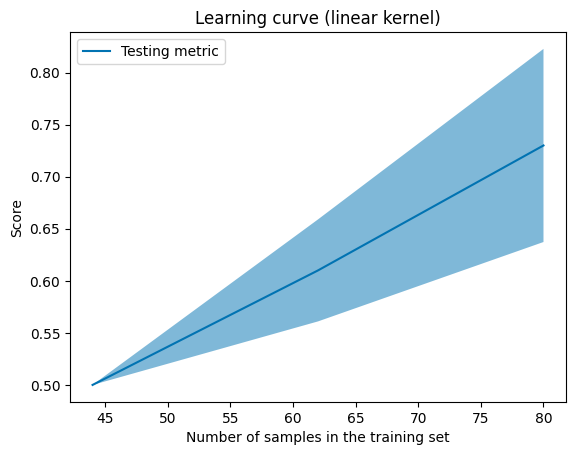

In [45]:
svm_linear = SVC(C=1.0, kernel='linear', probability=True)

train_sizes, train_scores, test_scores = learning_curve(svm_linear, X, y, cv=5)

display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")

display.plot()

plt.title("Learning curve (linear kernel)")
plt.legend(loc="upper left")

plt.show()

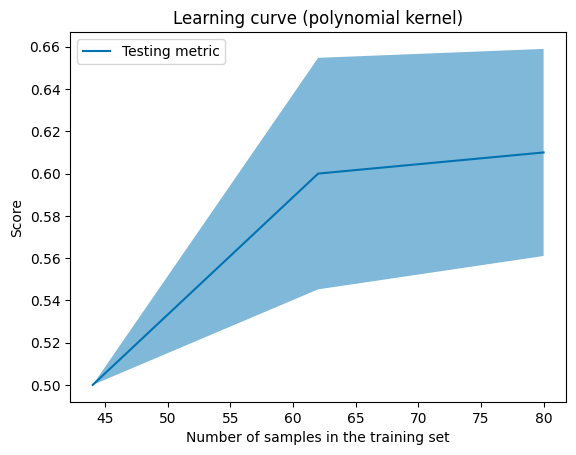

In [46]:
svm_polynomial = SVC(C=1, kernel='poly', degree=3, probability=True)

train_sizes, train_scores, test_scores = learning_curve(svm_polynomial, X, y, cv=5)

display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")

display.plot()

plt.title("Learning curve (polynomial kernel)")
plt.legend(loc="upper left")

plt.show()

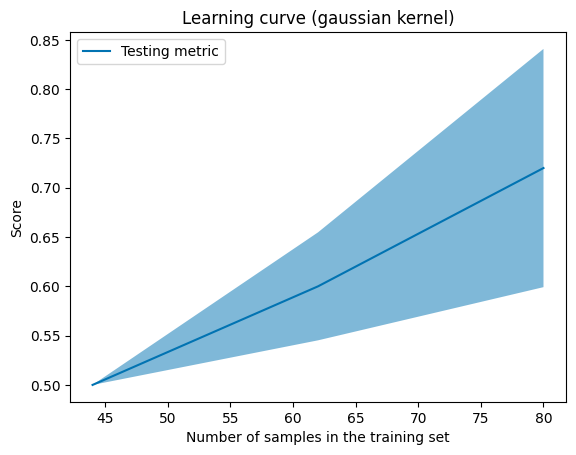

In [47]:
svm_rbf = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True)

train_sizes, train_scores, test_scores = learning_curve(svm_rbf, X, y, cv=5)

display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")

display.plot()

plt.title("Learning curve (gaussian kernel)")
plt.legend(loc="upper left")

plt.show()

### Question 3 :

Montrez que le problème primal résolu par le SVM peut se réécrire de la façon suivante :

$$ \mathop{argmin}_{w ∈ H , w_0 ∈ R} ~\big(~ \frac{1}{2}.||w||^2 + C.\sum_{i=1}^{n}[1 - y_i.(w^T⋅ϕ(x_i) + w_0)]_+ ~\big) $$

### Question 4 : 

Expliquez la phrase : "un SVM minimise l’erreur de classification à l’aide d’un majorant convexe
de la fonction qui vaut 1 quand la marge est négative et 0 sinon". La fonction $x → {[1 − x]}_{+} =
max(0, 1 − x)$ est appelée <i>Hinge</i> (<i>charnière</i> en français).

# SVM GUI

Lancez le script <i>svm_gui.py</i> disponible à l’adresse : http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html Cette application permet en temps réel d’évaluer l’impact
du choix du noyau et du paramètre de régularisation C.

![SNOWFALL](Screenshots/Screenshot_1.jpg)

Générez un jeu de données très déséquilibré avec beaucoup plus de points dans une classe que dans
l’autre (au moins 90% vs 10%).

![SNOWFALL](Screenshots/Screenshot_2.jpg)

Les points noirs représentent la classe $-1$, tandis que les points blancs représentent la classe $+1$.

A l’aide d’un noyau linéaire et en diminuant le paramètre $C$ qu’observez vous ?

En diminuant le paramètre $C$, on observe que la marge entre les deux vecteurs de supports devient plus grande.

<i>● Pour C = 0.00005 :</i>

![SNOWFALL](Screenshots/Screenshot_3.jpg)

<i>● Pour C = 10000 :</i>

![SNOWFALL](Screenshots/Screenshot_4.jpg)

Réciproquement, lorsque le paramètre $C$ augmente, la marge diminue.

# Classification de visages :

L’exemple suivant est un problème de classification de visages. La base de données à utiliser est
disponible à l’adresse suivante : https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html. Vous pouvez choisir deux personnes, par exemple Tony Blair et Colin
Powell, pour accélérer le calcul. Aussi, vous pouvez utilisez seulement grayscale (et non le couleur) pour
réduire le nombre de variables.

In [48]:
from sklearn.datasets import fetch_lfw_people

In [49]:
tony_target = np.where(fetch_lfw_people(color=False).target_names == 'Tony Blair')[0][0]
colin_target = np.where(fetch_lfw_people(color=False).target_names == 'Colin Powell')[0][0]

print("Tony Blair : ", tony_target)
print("Colin Powell : ", colin_target)

Tony Blair :  5458
Colin Powell :  1047


In [50]:
# indices des photos correspondant à Tony Blair
tony_indices = np.where(fetch_lfw_people(color=False).target == tony_target)[0]

# indices des photos correspondant à Colin Powell
colin_indices = np.where(fetch_lfw_people(color=False).target == colin_target)[0]

print("Nombre de photos de Tony Blair = ", len(tony_indices))
print("Nombre de photos de Colin Powell = ", len(colin_indices))

Nombre de photos de Tony Blair =  144
Nombre de photos de Colin Powell =  236


In [51]:
tony_data = fetch_lfw_people(color=False).data[list(tony_indices)]
colin_data = fetch_lfw_people(color=False).data[list(colin_indices)]

tony_images = fetch_lfw_people(color=False).images[list(tony_indices)]
colin_images = fetch_lfw_people(color=False).images[list(colin_indices)]

print("tony_data shape : ", tony_data.shape)
print("colin_data shape : ", colin_data.shape)
print("\ntony_images shape : ", tony_images.shape)
print("colin_images shape : ", colin_images.shape)

tony_data shape :  (144, 2914)
colin_data shape :  (236, 2914)

tony_images shape :  (144, 62, 47)
colin_images shape :  (236, 62, 47)


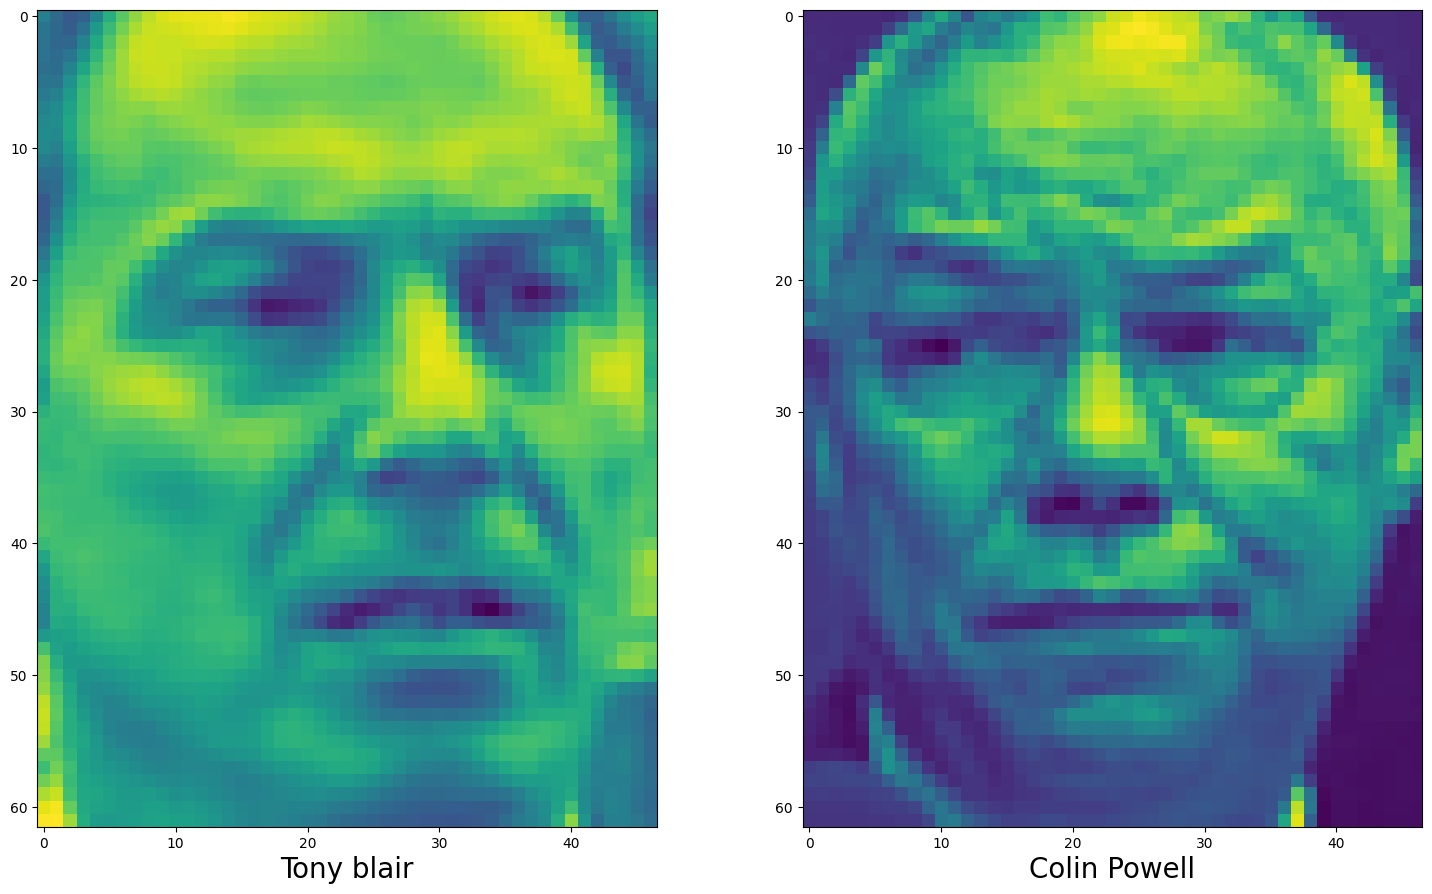

In [52]:
plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(tony_images[0], interpolation='nearest')
plt.xlabel("Tony blair", fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(colin_images[0], interpolation='nearest')
plt.xlabel("Colin Powell", fontsize=20)
    
plt.tight_layout(pad=5.0)

### Question 5 :

Pourquoi nous devons utiliser des features centrées et réduites ?

La normalisation des données est une étape importante qui garantit que chaque paramètre d'entrée (pixel, dans ce cas) a une distribution de données similaire. Cela rend la convergence plus rapide lors de l'entrainement de notre modèle.

In [53]:
data = np.append(tony_data , colin_data, axis=0)

print("data shape : ", data.shape)
print("\nNombre d'exemples : ", data.shape[0])
print("Nombre de features : ", data.shape[1])

data shape :  (380, 2914)

Nombre d'exemples :  380
Nombre de features :  2914


On affecte la classe $-1$ à Tony Blair et la classe $1$ à Colin Powell :

In [54]:
target = np.append(np.full((tony_data.shape[0],), -1) , np.full((colin_data.shape[0],), 1))

print("target shape : ", target.shape)
print("\nNombre d'exemples correspondant à Tony Blair (classe -1) : ", len(np.where(target == -1)[0]))
print("Nombre d'exemples correspondant à Colin Powell (classe 1) : ", len(np.where(target == 1)[0]))

target shape :  (380,)

Nombre d'exemples correspondant à Tony Blair (classe -1) :  144
Nombre d'exemples correspondant à Colin Powell (classe 1) :  236


On mélange nos exemples :

In [55]:
ind = np.random.permutation(data.shape[0])
np.random.shuffle(ind)

data = data[ind, :]
target = target[ind]

### Question 6 :

Montrez l’influence du paramètre de régularisation. On pourra par exemple afficher l’erreur de
prédiction en fonction de $C$ sur une échelle logarithmique entre 1e5 et 1e-5.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=20)

print("Nombre d'exemples d'apprentissage : ", len(y_train))
print("Nombre d'exemples de test : ", len(y_test))

Nombre d'exemples d'apprentissage :  285
Nombre d'exemples de test :  95


On normalise nos features :

In [57]:
# Normalisation
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train) # Normalisation de X_train
X_test_std = scaler.transform(X_test) # Normalisation de X_test en utilisant les paramètres de X_train

In [58]:
errors_lin = []
errors_poly = []
errors_rbf = []

for c in np.logspace(start=-5, stop=5, num=11) :
    
    svm_linear = SVC(C=c, kernel='linear', probability=True)
    svm_polynomial = SVC(C=c, kernel='poly', degree=3, probability=True)
    svm_rbf = SVC(C=c, kernel='rbf', gamma='scale', probability=True)
    
    svm_linear.fit(X_train_std, y_train)
    svm_polynomial.fit(X_train_std, y_train)
    svm_rbf.fit(X_train_std, y_train)
    
    errors_lin.append(1 - svm_linear.score(X_test_std, y_test))
    errors_poly.append(1 - svm_polynomial.score(X_test_std, y_test))
    errors_rbf.append(1 - svm_rbf.score(X_test_std, y_test))

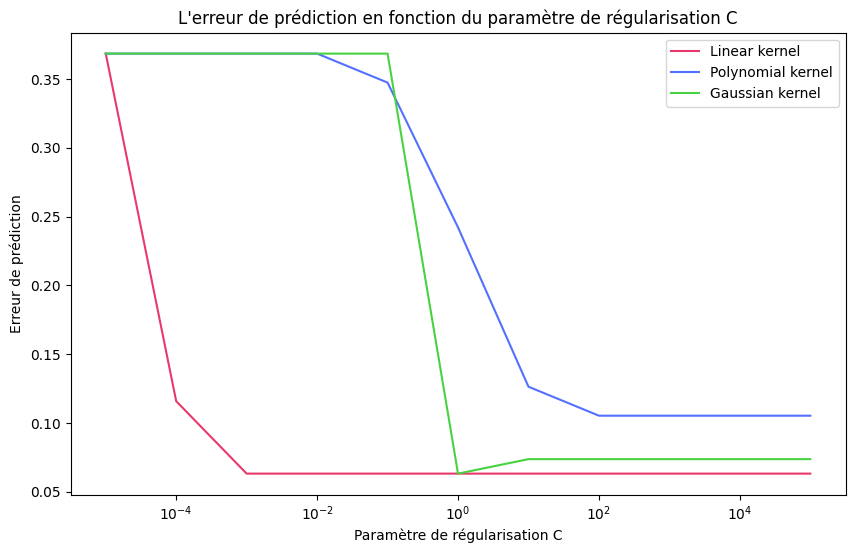

In [59]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.logspace(start=-5, stop=5, num=11), errors_lin, color="#E9386B", label="Linear kernel")
ax.plot(np.logspace(start=-5, stop=5, num=11), errors_poly, color="#5470FE", label="Polynomial kernel")
ax.plot(np.logspace(start=-5, stop=5, num=11), errors_rbf, color="#47D341", label="Gaussian kernel")

ax.set_xscale('log')

plt.title("L'erreur de prédiction en fonction du paramètre de régularisation C")
plt.xlabel('Paramètre de régularisation C')
plt.ylabel('Erreur de prédiction')

plt.legend(loc='upper right')
plt.show()

### Question 7 :

En ajoutant des variables de nuisance (par exemple $2046$ variables normales centrées réduites),
augmentant ainsi le nombre de variables à nombre de points d’apprentissage fixé, montrez que la
performance chute.

In [60]:
noise_train = np.random.rand(X_train.shape[0], 2046)
noise_test = np.random.rand(X_test.shape[0], 2046)

X_train_noise = np.concatenate((X_train, noise_train), axis=1)
X_test_noise = np.concatenate((X_test, noise_test), axis=1)

scaler = StandardScaler()

X_train_noise = scaler.fit_transform(X_train_noise)
X_test_noise = scaler.transform(X_test_noise)

variables_ind = np.random.permutation(X_train_noise.shape[1])
np.random.shuffle(variables_ind)

X_train_noise = X_train_noise[:, variables_ind]
X_test_noise = X_test_noise[:, variables_ind]

print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("X_train_noise shape : ", X_train_noise.shape)
print("X_test_noise shape : ", X_test_noise.shape)

X_train shape :  (285, 2914)
X_test shape :  (95, 2914)
X_train_noise shape :  (285, 4960)
X_test_noise shape :  (95, 4960)


In [61]:
errors_lin_noise = []
errors_poly_noise = []
errors_rbf_noise = []

for c in np.logspace(start=-5, stop=5, num=11) :
    
    svm_linear = SVC(C=c, kernel='linear', probability=True)
    svm_polynomial = SVC(C=c, kernel='poly', degree=3, probability=True)
    svm_rbf = SVC(C=c, kernel='rbf', gamma='scale', probability=True)
    
    svm_linear.fit(X_train_noise, y_train)
    svm_polynomial.fit(X_train_noise, y_train)
    svm_rbf.fit(X_train_noise, y_train)
    
    errors_lin_noise.append(1 - svm_linear.score(X_test_noise, y_test))
    errors_poly_noise.append(1 - svm_polynomial.score(X_test_noise, y_test))
    errors_rbf_noise.append(1 - svm_rbf.score(X_test_noise, y_test))

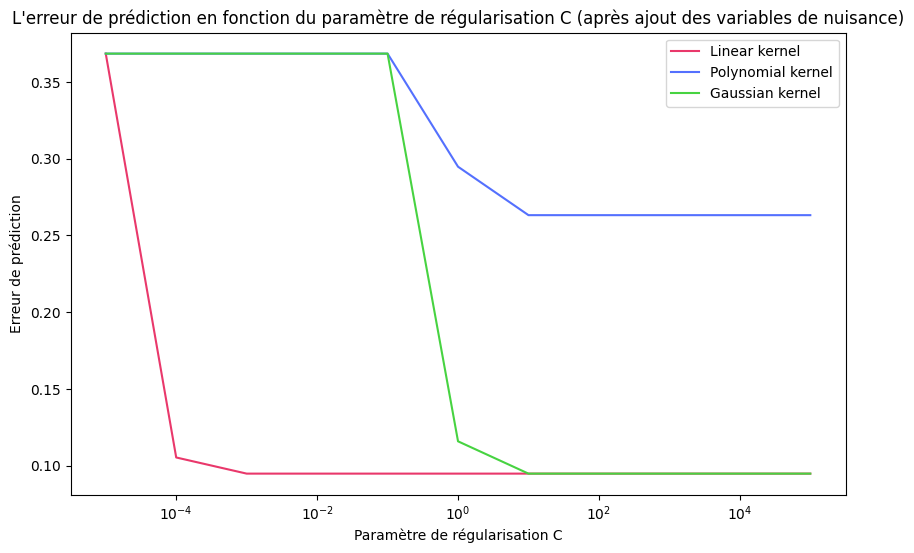

In [62]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.logspace(start=-5, stop=5, num=11), errors_lin_noise, color="#E9386B", label="Linear kernel")
ax.plot(np.logspace(start=-5, stop=5, num=11), errors_poly_noise, color="#5470FE", label="Polynomial kernel")
ax.plot(np.logspace(start=-5, stop=5, num=11), errors_rbf_noise, color="#47D341", label="Gaussian kernel")

ax.set_xscale('log')

plt.title("L'erreur de prédiction en fonction du paramètre de régularisation C (après ajout des variables de nuisance)")
plt.xlabel('Paramètre de régularisation C')
plt.ylabel('Erreur de prédiction')

plt.legend(loc='upper right')
plt.show()

Comparaisons avec C = 10 :

In [63]:
svm_linear = SVC(C=10, kernel='linear', probability=True)
svm_polynomial = SVC(C=10, kernel='poly', degree=3, probability=True)
svm_rbf = SVC(C=10, kernel='rbf', gamma='scale', probability=True)

svm_linear.fit(X_train_std, y_train)
svm_polynomial.fit(X_train_std, y_train)
svm_rbf.fit(X_train_std, y_train)

print("Before adding noise data :")
print("Accuracy (linear kernel) : "+str(round(svm_linear.score(X_test_std, y_test)*100,4))+" %")
print("Accuracy (polynomial kernel) : "+str(round(svm_polynomial.score(X_test_std, y_test)*100,4))+" %")
print("Accuracy (gaussian kernel) : "+str(round(svm_rbf.score(X_test_std, y_test)*100,4))+" %")

svm_linear.fit(X_train_noise, y_train)
svm_polynomial.fit(X_train_noise, y_train)
svm_rbf.fit(X_train_noise, y_train)

print("\nAfter adding noise data :")
print("Accuracy (linear kernel) : "+str(round(svm_linear.score(X_test_noise, y_test)*100,4))+" %")
print("Accuracy (polynomial kernel) : "+str(round(svm_polynomial.score(X_test_noise, y_test)*100,4))+" %")
print("Accuracy (gaussian kernel) : "+str(round(svm_rbf.score(X_test_noise, y_test)*100,4))+" %")

Before adding noise data :
Accuracy (linear kernel) : 93.6842 %
Accuracy (polynomial kernel) : 87.3684 %
Accuracy (gaussian kernel) : 92.6316 %

After adding noise data :
Accuracy (linear kernel) : 90.5263 %
Accuracy (polynomial kernel) : 73.6842 %
Accuracy (gaussian kernel) : 90.5263 %


On remarque clairement que la performance chute après avoir ajouté les variables de nuisance.

### Question 8 :

Vous pourrez améliorer la prédiction à l’aide d’une réduction de dimension basée sur l’objet
sklearn.decomposition.PCA.

On doit d'abord choisir le nombre de composantes principales en utilisant la méthode du coude :

Tout d'abord, on normalise nos données d'entrée (data) :

In [64]:
scaler = StandardScaler()

data_std = scaler.fit_transform(data)

On donne la matrice de covariance calculée sur data (données d'entrée) :

In [65]:
# Matrice de covariance
n_samples = data_std.shape[0]

Cov_Mat = (1/n_samples) * (data_std.T @ data_std)
pd.DataFrame(Cov_Mat)

0         1         2         3         4         5         6     \
0     1.000000  0.957325  0.829579  0.669367  0.571472  0.496005  0.430810   
1     0.957325  1.000000  0.922867  0.748239  0.625309  0.524455  0.432754   
2     0.829579  0.922867  1.000000  0.900807  0.738057  0.589302  0.467621   
3     0.669367  0.748239  0.900807  1.000000  0.910482  0.727583  0.580974   
4     0.571472  0.625309  0.738057  0.910482  1.000000  0.909465  0.739743   
...        ...       ...       ...       ...       ...       ...       ...   
2909 -0.101059 -0.077312 -0.042026  0.000402  0.044133  0.059356  0.056243   
2910 -0.102973 -0.072608 -0.039225 -0.010366  0.026110  0.040823  0.043850   
2911 -0.127120 -0.085192 -0.045803 -0.023921  0.004437  0.009180  0.017353   
2912 -0.134082 -0.090893 -0.058362 -0.041468 -0.020975 -0.023037 -0.000361   
2913 -0.113393 -0.078806 -0.074836 -0.080130 -0.063197 -0.059880 -0.022605   

          7         8         9     ...      2904      2905      2906  \
0     0.360210  0.320601  0.324576  ... -0.083587 -0.057336 -0.033612   
1     0.349654  0.315257  0.325889  ... -0.050967 -0.024302 -0.002964   
2     0.359207  0.318189  0.322647  ... -0.026101  0.009178  0.039231   
3     0.447136  0.388683  0.378381  ...  0.008113  0.044898  0.070388   
4     0.557708  0.473196  0.465939  ...  0.040802  0.057781  0.067097   
...        ...       ...       ...  ...       ...       ...       ...   
2909  0.031106  0.004805 -0.006372  ...  0.347621  0.512873  0.640817   
2910  0.035123  0.021992  0.026403  ...  0.202990  0.341309  0.461906   
2911  0.032110  0.031642  0.044812  ...  0.103159  0.206836  0.306949   
2912  0.033940  0.044661  0.064988  ...  0.052771  0.115218  0.184962   
2913  0.026655  0.041524  0.058572  ...  0.019541  0.053807  0.099656   

          2907      2908      2909      2910      2911      2912      2913  
0    -0.046574 -0.084570 -0.101059 -0.102973 -0.127120 -0.134082 -0.113393  
1    -0.014765 -0.052389 -0.077312 -0.072608 -0.085192 -0.090893 -0.078806  
2     0.031493 -0.006644 -0.042026 -0.039225 -0.045803 -0.058362 -0.074836  
3     0.063376  0.035305  0.000402 -0.010366 -0.023921 -0.041468 -0.080130  
4     0.070261  0.065625  0.044133  0.026110  0.004437 -0.020975 -0.063197  
...        ...       ...       ...       ...       ...       ...       ...  
2909  0.748841  0.912591  1.000000  0.904712  0.702786  0.528559  0.393679  
2910  0.569294  0.730111  0.904712  1.000000  0.902303  0.714150  0.556273  
2911  0.403075  0.537479  0.702786  0.902303  1.000000  0.899447  0.733838  
2912  0.265396  0.384675  0.528559  0.714150  0.899447  1.000000  0.930103  
2913  0.163836  0.263951  0.393679  0.556273  0.733838  0.930103  1.000000  

[2914 rows x 2914 columns]

Ensuite, on trace le graphe de la décroissance des valeurs propres de la matrice de covariance :

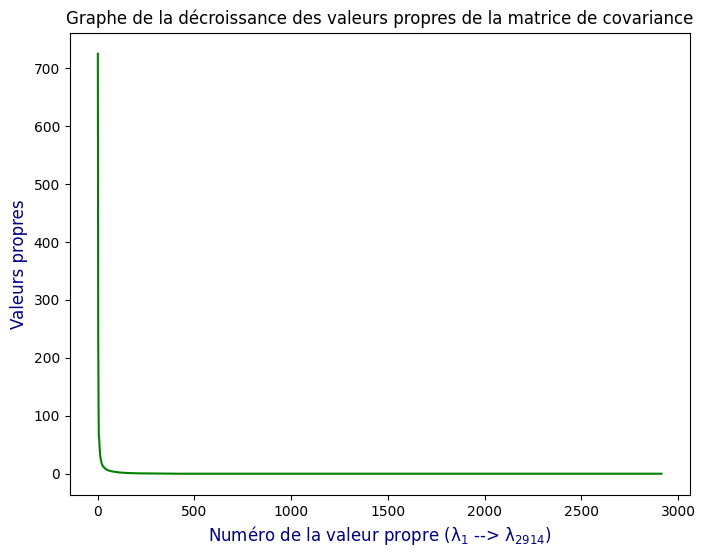

In [66]:
val_prop = np.flip(np.linalg.eigh(Cov_Mat)[0] , axis=0)

fig = plt.figure(figsize=(8,6))

plt.plot([i for i in range(1, data_std.shape[1] + 1)], val_prop, color='green')

plt.title("Graphe de la décroissance des valeurs propres de la matrice de covariance")
plt.xlabel("Numéro de la valeur propre (λ$_{%d}$"%1+" --> λ$_{%d}$"%data_std.shape[1]+")", color='navy', fontsize=12)
plt.ylabel("Valeurs propres", color='navy', fontsize=12)

plt.show()

Le pourcentage de variance expliqué par chaque axe :

In [67]:
Inertie_totale = val_prop.sum()
proportions_inertie = [val/Inertie_totale for val in val_prop]

df_proportions = pd.DataFrame(data = {'Valeurs propres': list(np.around(val_prop, 5)),
                                      'Proportions': list(np.around(np.array(proportions_inertie), 5)),
                                      'Proportions cumulées' : list(np.around(np.cumsum(proportions_inertie), 5))},
                              index = ['Axe '+str(i) for i in range(1, data_std.shape[1] + 1)],)

df_proportions.head(10)

Valeurs propres  Proportions  Proportions cumulées
Axe_1        724.688904      0.24869               0.24869
Axe_2        420.876556      0.14443               0.39312
Axe_3        232.169067      0.07967               0.47280
Axe_4        143.788269      0.04934               0.52214
Axe_5        105.372490      0.03616               0.55830
Axe_6         66.667618      0.02288               0.58118
Axe_7         62.874390      0.02158               0.60276
Axe_8         57.544300      0.01975               0.62251
Axe_9         54.656422      0.01876               0.64126
Axe_10        45.616829      0.01565               0.65692

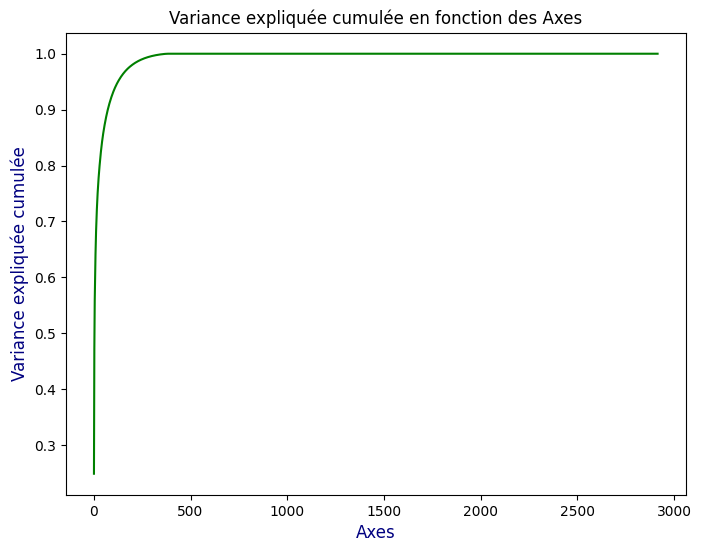

In [68]:
fig = plt.figure(figsize=(8,6))

plt.plot([i for i in range(1, data_std.shape[1] + 1)], np.cumsum(proportions_inertie), color='green')

plt.title("Variance expliquée cumulée en fonction des axes")
plt.xlabel("Axes", color='navy', fontsize=12)
plt.ylabel("Variance expliquée cumulée", color='navy', fontsize=12)

plt.show()

In [69]:
# Deuxième méthode
from sklearn.decomposition import PCA

pca = PCA(n_components=10) # On veut les 10 premières composantes principales
pca.fit(data_std)

proportions = pca.explained_variance_ratio_

pd.DataFrame(data = {'Valeurs propres': list(np.around(val_prop[:10], 5)),
                     'Proportions': list(np.around(np.array(proportions), 5)),
                     'Proportions cumulées' : list(np.around(np.cumsum(proportions), 5))},
             index = ['Axe_'+str(i) for i in range(1, 11)],)

Valeurs propres  Proportions  Proportions cumulées
Axe_1        724.688904      0.24869               0.24869
Axe_2        420.876556      0.14443               0.39312
Axe_3        232.169067      0.07967               0.47280
Axe_4        143.788269      0.04934               0.52214
Axe_5        105.372490      0.03616               0.55830
Axe_6         66.667618      0.02288               0.58118
Axe_7         62.874390      0.02158               0.60276
Axe_8         57.544300      0.01975               0.62251
Axe_9         54.656422      0.01876               0.64126
Axe_10        45.616829      0.01565               0.65692

Avec 10 axes, on a réussi à expliquer uniquement 65% de la variance totale. 

Ainsi, on va essayer de sélectionner le nombre de composantes principales de telle sorte qu'on récupère 90% de la variance totale :

In [70]:
n_composantes = len(df_proportions.loc[df_proportions['Proportions cumulées'] <= 0.9]) + 1

print("Nombre de composantes principales : ", n_composantes)
print("Pourcentage de variance expliquée : " + str(round(df_proportions.iloc[n_composantes-1, 2]*100, 3)) + " %") 

Nombre de composantes principales :  73
Pourcentage de variance expliquée : 90.068 %


Avec $73$ composantes principales, on a pu récupérer $90.068~\text{%}$ de la variance totale.

In [71]:
# Deuxième méthode
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9) # On veut récupérer plus de 90% de la variance totale
pca.fit(data_std)

print("Nombre de composantes principales : ", pca.n_components_)
print("Pourcentage de variance expliquée : " + str(round(np.sum(pca.explained_variance_ratio_)*100, 3)) + " %")

Nombre de composantes principales :  73
Pourcentage de variance expliquée : 90.068 %


In [72]:
n_composantes = pca.n_components_
proportions = pca.explained_variance_ratio_

pd.DataFrame(data = {'Valeurs propres': list(np.around(val_prop[:n_composantes], 5)),
                     'Proportions': list(np.around(np.array(proportions), 5)),
                     'Proportions cumulées' : list(np.around(np.cumsum(proportions), 5))},
             index = ['Axe_'+str(i) for i in range(1, n_composantes+1)],)

Valeurs propres  Proportions  Proportions cumulées
Axe_1        724.688904      0.24869               0.24869
Axe_2        420.876556      0.14443               0.39312
Axe_3        232.169067      0.07967               0.47280
Axe_4        143.788269      0.04934               0.52214
Axe_5        105.372490      0.03616               0.55830
...                 ...          ...                   ...
Axe_69         4.426590      0.00152               0.89489
Axe_70         4.343740      0.00149               0.89638
Axe_71         4.244080      0.00146               0.89784
Axe_72         4.204900      0.00144               0.89928
Axe_73         4.056910      0.00139               0.90068

[73 rows x 3 columns]

Après, on applique la PCA aux données <i>data</i> :

In [73]:
data_pca = pca.transform(data_std)

pd.DataFrame(data = data_pca,
             columns = ['Axe'+str(i) for i in range(1, n_composantes+1)])

Axe1       Axe2       Axe3       Axe4       Axe5       Axe6  \
0    22.962755  15.042025  11.328764  10.698311  16.070284  -2.041335   
1    39.435642   5.429725   1.093746  12.837604  24.813122   6.601458   
2     2.643183 -19.900923  -7.609660  -8.268930  -8.046188  -2.295395   
3    18.154020  11.960644  -3.085434 -16.885088  -0.928653  13.261809   
4    10.821579  -4.515152 -25.277128  -8.403872  -5.687035  -6.607090   
..         ...        ...        ...        ...        ...        ...   
375  16.751778 -17.632895   4.555303   2.919210  21.759434  -1.131227   
376  13.193461 -10.946224  19.521082  -5.173373   9.676891  11.271728   
377   0.107746  -4.332273 -17.064222   6.122624  -4.576897   1.689400   
378 -22.423048 -15.209425  -9.411798   1.049644  -7.317865   8.819820   
379 -38.119225   7.888010  -7.133821   5.683282   3.867154   5.317153   

          Axe7       Axe8      Axe9     Axe10  ...     Axe64     Axe65  \
0    -6.157578  -5.104919 -0.532418 -6.228261  ...  1.300713 -0.553838   
1     3.017865  -8.844133  1.833229  1.579351  ...  0.739874  0.468321   
2    11.511237   3.733443  4.688370  7.647781  ...  0.233132 -1.574966   
3     2.869741  14.777327 -5.655517 -1.381390  ... -0.992487  2.142200   
4     4.278040  -4.237502 -1.581012  2.010189  ... -0.456113 -2.285821   
..         ...        ...       ...       ...  ...       ...       ...   
375  -4.258618 -17.637520  0.635203  0.231643  ...  0.101985  1.170411   
376  18.743687  -2.910760  0.379768 -4.978713  ...  0.582786  1.477749   
377   0.526873  -1.974080 -2.466843 -2.691470  ... -1.172630 -2.226841   
378  -5.839762   1.457658 -3.534196  7.213958  ... -3.974858 -2.559368   
379   7.074325  -3.895068  0.589419 -5.956931  ... -1.688544  0.781073   

        Axe66     Axe67     Axe68     Axe69     Axe70     Axe71     Axe72  \
0   -1.356504  1.002570  1.024383 -3.012428 -3.714119 -4.448302  1.222431   
1    0.958538 -0.002034 -3.249461 -0.357186 -0.508007  3.012631  1.383286   
2   -2.234530 -0.552091  1.737742  3.980261  0.710781  0.865669 -3.730368   
3    3.671382  1.677622 -1.809248 -0.562295 -1.204374  0.776027 -2.125055   
4    0.088375 -0.159088  1.389507 -1.252337 -0.866640  2.177106 -1.458421   
..        ...       ...       ...       ...       ...       ...       ...   
375  1.777117 -4.647399  0.361108 -0.486392  3.098531  2.872295 -4.552025   
376  0.794583 -0.509080  0.062683  2.579051 -2.822808  3.004642  0.735454   
377  1.101467  1.718141 -0.738374  0.361619 -0.139909 -0.095964 -0.276486   
378  4.652499  1.698875  3.246744  6.960844  2.187844 -0.768487 -1.150327   
379 -2.388114  0.839976  1.680075  0.257526  0.123439  0.299610 -1.635760   

        Axe73  
0    0.477848  
1    1.813064  
2   -4.703080  
3    1.003798  
4    2.371232  
..        ...  
375  1.973332  
376 -0.679908  
377  0.181799  
378 -1.425015  
379  1.904265  

[380 rows x 73 columns]

Maintenant, si on divise notre ensemble en deux sets (Train et Test), on va devoir les normaliser et appliquer la PCA sur chacun d'eux, tout en utilisant le Train set :

In [74]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=20)

In [75]:
# Normalisation
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train) # Normalisation de X_train
X_test_std = scaler.transform(X_test) # Normalisation de X_test en utilisant les paramètres de X_train

In [76]:
# PCA
pca = PCA(n_components=0.9) # On veut récupérer plus de 90% de la variance totale
X_train_PCA = pca.fit_transform(X_train_std)  # On fit sur les données d'entrainement afin de trouver le nouvel espace
X_test_PCA = pca.transform(X_test_std) # On projette les données de test sur le même espace

In [77]:
# L'erreur de prédiction en fonction du paramètre de régularisation C
errors_lin_PCA = []
errors_poly_PCA = []
errors_rbf_PCA = []

for c in np.logspace(start=-5, stop=5, num=11) :
    
    svm_linear = SVC(C=c, kernel='linear', probability=True)
    svm_polynomial = SVC(C=c, kernel='poly', degree=3, probability=True)
    svm_rbf = SVC(C=c, kernel='rbf', gamma='scale', probability=True)
    
    svm_linear.fit(X_train_PCA, y_train)
    svm_polynomial.fit(X_train_PCA, y_train)
    svm_rbf.fit(X_train_PCA, y_train)
    
    errors_lin_PCA.append(1 - svm_linear.score(X_test_PCA, y_test))
    errors_poly_PCA.append(1 - svm_polynomial.score(X_test_PCA, y_test))
    errors_rbf_PCA.append(1 - svm_rbf.score(X_test_PCA, y_test))

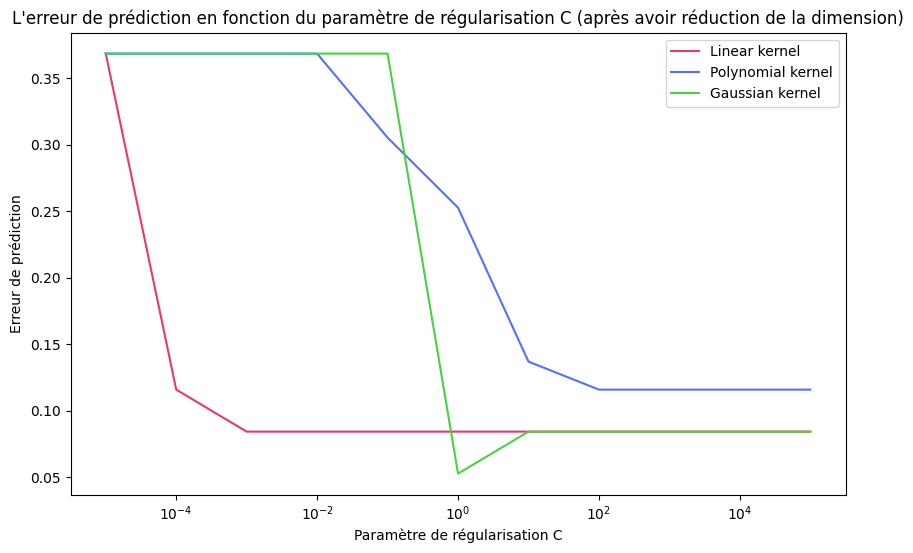

In [78]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.logspace(start=-5, stop=5, num=11), errors_lin_PCA, color="#E9386B", label="Linear kernel")
ax.plot(np.logspace(start=-5, stop=5, num=11), errors_poly_PCA, color="#5470FE", label="Polynomial kernel")
ax.plot(np.logspace(start=-5, stop=5, num=11), errors_rbf_PCA, color="#47D341", label="Gaussian kernel")

ax.set_xscale('log')

plt.title("L'erreur de prédiction en fonction du paramètre de régularisation C (après avoir réduction de la dimension)")
plt.xlabel('Paramètre de régularisation C')
plt.ylabel('Erreur de prédiction')

plt.legend(loc='upper right')
plt.show()

Comparaisons avec C = 10 :

In [79]:
svm_linear = SVC(C=10, kernel='linear', probability=True)
svm_polynomial = SVC(C=10, kernel='poly', degree=3, probability=True)
svm_rbf = SVC(C=10, kernel='rbf', gamma='scale', probability=True)

svm_linear.fit(X_train_std, y_train)
svm_polynomial.fit(X_train_std, y_train)
svm_rbf.fit(X_train_std, y_train)

print("Before applying PCA :")
print("Accuracy (linear kernel) : "+str(round(svm_linear.score(X_test_std, y_test)*100,4))+" %")
print("Accuracy (polynomial kernel) : "+str(round(svm_polynomial.score(X_test_std, y_test)*100,4))+" %")
print("Accuracy (gaussian kernel) : "+str(round(svm_rbf.score(X_test_std, y_test)*100,4))+" %")

svm_linear.fit(X_train_PCA, y_train)
svm_polynomial.fit(X_train_PCA, y_train)
svm_rbf.fit(X_train_PCA, y_train)

print("\nAfter applying PCA :")
print("Accuracy (linear kernel) : "+str(round(svm_linear.score(X_test_PCA, y_test)*100,4))+" %")
print("Accuracy (polynomial kernel) : "+str(round(svm_polynomial.score(X_test_PCA, y_test)*100,4))+" %")
print("Accuracy (gaussian kernel) : "+str(round(svm_rbf.score(X_test_PCA, y_test)*100,4))+" %")

Before applying PCA :
Accuracy (linear kernel) : 93.6842 %
Accuracy (polynomial kernel) : 87.3684 %
Accuracy (gaussian kernel) : 92.6316 %

After applying PCA :
Accuracy (linear kernel) : 91.5789 %
Accuracy (polynomial kernel) : 86.3158 %
Accuracy (gaussian kernel) : 91.5789 %
